In [ ]:
# Install Optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 8.2 MB/s eta 0:00:00


In [ ]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import optuna
import json
import gc
import math
import numpy as np
import logging

# Initialize logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

@dataclass
class Config:
    # Environment Settings
    grid_size: int = 20
    start: tuple = (0, 0)
    destination: tuple = (19, 19)

    # DQN Hyperparameters
    actions: list = ((0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (1, 1), (1, -1), (-1, 1))
    gamma: float = 0.99
    learning_rate: float = 0.001
    batch_size: int = 64
    memory_capacity: int = 10000
    epsilon: float = 1.0
    epsilon_decay: float = 0.995
    epsilon_min: float = 0.1
    target_update: int = 5
    hidden_size: int = 128  # Example additional hyperparameter

    # Transformer-specific hyperparameters
    use_transformer: bool = False  # Will be set per study
    transformer_nhead: int = 4
    transformer_num_layers: int = 2
    positional_encoding_dim: int = 128  # Dimension for positional encoding

    # Prioritized Replay Buffer hyperparameters
    use_prioritized_replay: bool = False
    alpha: float = 0.6  # How much prioritization is used (0 - no prioritization, 1 - full)
    beta_start: float = 0.4  # Initial value of beta for importance-sampling
    beta_frames: int = 100000  # Number of frames over which beta will be annealed from beta_start to 1.0

    # Device configuration
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model: Dimension of the embedding
            max_len: Maximum length of sequences
        """
        super(PositionalEncoding, self).__init__()

        # Create a long enough P matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Compute the positional encodings once in log space
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # If d_model is odd, skip the last term for cosine
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, sequence_length, d_model)
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return x

class SumTree:
    """
    SumTree data structure for Prioritized Experience Replay.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # Sum tree
        self.data = np.zeros(capacity, dtype=object)  # Experience
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[data_idx])

    @property
    def total_priority(self):
        return self.tree[0]

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.tree = SumTree(capacity)
        self.alpha = alpha
        self.capacity = capacity
        self.max_priority = 1.0  # Initial max priority

    def add(self, experience):
        priority = self.max_priority
        self.tree.add(priority ** self.alpha, experience)

    def sample(self, batch_size, beta=0.4):
        batch = []
        idxs = []
        segment = self.tree.total_priority / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, priority, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(priority)

        sampling_probabilities = priorities / self.tree.total_priority
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -beta)
        is_weight /= is_weight.max()
        is_weight = torch.tensor(is_weight, dtype=torch.float)  # Keep on CPU

        return batch, idxs, is_weight

    def update_priorities(self, idxs, priorities):
        for idx, priority in zip(idxs, priorities):
            priority = max(priority, 1e-6)  # Avoid zero priority
            self.tree.update(idx, priority ** self.alpha)
            self.max_priority = max(self.max_priority, priority)

class DQN(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        config: Config
    ):
        super(DQN, self).__init__()
        self.use_transformer = config.use_transformer
        self.device = config.device
        self.hidden_size = config.hidden_size

        if self.use_transformer:
            logger.info("Initializing Transformer layers with batch_first=True.")
            # Input projection to hidden_size
            self.input_proj = nn.Linear(input_dim, self.hidden_size)

            # Positional Encoding
            self.pos_encoder = PositionalEncoding(self.hidden_size)

            # Ensure hidden_size is divisible by nhead
            assert self.hidden_size % config.transformer_nhead == 0, "hidden_size must be divisible by transformer_nhead"

            # Initialize Transformer Encoder with batch_first=True
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.hidden_size,
                    nhead=config.transformer_nhead,
                    batch_first=True  # Important to set batch_first=True
                ),
                num_layers=config.transformer_num_layers
            )
            self.fc = nn.Sequential(
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, output_dim)
            )
        else:
            logger.info("Initializing fully connected layers without Transformer.")
            self.fc = nn.Sequential(
                nn.Linear(input_dim, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, output_dim)
            )

        # Move model to device
        self.to(self.device)

    def forward(self, x):
        if self.use_transformer:
            x = self.input_proj(x)          # Shape: (batch_size, hidden_size)
            x = x.unsqueeze(1)              # Shape: (batch_size, 1, hidden_size)
            x = self.pos_encoder(x)         # Shape: (batch_size, 1, hidden_size)
            x = self.transformer(x)         # Shape: (batch_size, 1, hidden_size)
            x = x.squeeze(1)                # Shape: (batch_size, hidden_size)
        return self.fc(x)

class Agent:
    def __init__(self, config: Config):
        self.config = config
        self.device = config.device  # Get device from config
        self.eval_net = DQN(
            input_dim=2,
            output_dim=len(config.actions),
            config=config
        )
        self.target_net = DQN(
            input_dim=2,
            output_dim=len(config.actions),
            config=config
        )
        self.target_net.load_state_dict(self.eval_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=config.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.epsilon = config.epsilon

        if config.use_prioritized_replay:
            self.memory = PrioritizedReplayBuffer(config.memory_capacity, alpha=config.alpha)
            self.beta = config.beta_start
            self.beta_increment = (1.0 - config.beta_start) / config.beta_frames
        else:
            self.memory = deque(maxlen=config.memory_capacity)

        # Log device information
        logger.info(f"Eval Net is on device: {next(self.eval_net.parameters()).device}")
        logger.info(f"Target Net is on device: {next(self.target_net.parameters()).device}")

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, len(self.config.actions) - 1)
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)  # Move to device
        with torch.no_grad():
            q_values = self.eval_net(state)
        return torch.argmax(q_values).item()

    def store_transition(self, transition):
        if self.config.use_prioritized_replay:
            self.memory.add(transition)
        else:
            self.memory.append(transition)

    def train_step(self):
        if self.config.use_prioritized_replay:
            if self.memory.tree.n_entries < self.config.batch_size:
                return

            batch, idxs, is_weights = self.memory.sample(self.config.batch_size, self.beta)
            # Move is_weights to device
            is_weights = is_weights.to(self.device).unsqueeze(1)  # Shape: (batch_size, 1)
            # Update beta
            self.beta = min(1.0, self.beta + self.beta_increment)
        else:
            if len(self.memory) < self.config.batch_size:
                return

            batch = random.sample(self.memory, self.config.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and move to device
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float).unsqueeze(1).to(self.device)

        if self.config.use_prioritized_replay:
            # is_weights is already on device and unsqueezed
            pass

        # Current Q values
        q_eval = self.eval_net(states).gather(1, actions).squeeze(1)

        # Next Q values from target network
        with torch.no_grad():
            q_next = self.target_net(next_states).max(1)[0].unsqueeze(1)

        # Compute target Q values
        q_target = rewards + self.config.gamma * q_next * (1 - dones)

        if self.config.use_prioritized_replay:
            # Compute TD errors
            td_errors = q_target.squeeze(1) - q_eval
            loss = (torch.pow(td_errors, 2) * is_weights.squeeze(1)).mean()
        else:
            # Compute loss
            loss = self.loss_fn(q_eval, q_target.squeeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.config.use_prioritized_replay:
            # Update priorities
            new_priorities = torch.abs(td_errors.detach()).cpu().numpy() + 1e-6
            self.memory.update_priorities(idxs, new_priorities)

        # Update epsilon
        if self.epsilon > self.config.epsilon_min:
            self.epsilon *= self.config.epsilon_decay

    def update_target_network(self):
        self.target_net.load_state_dict(self.eval_net.state_dict())

class GridEnvironment:
    def __init__(self, config: Config):
        self.config = config  # Assign config to self.config
        self.grid_size = config.grid_size
        self.start = config.start
        self.destination = config.destination
        self.reset()

    def reset(self):
        """Reset the environment to the initial state."""
        self.robot_pos = self.start
        self.steps = 0
        self.done = False
        return self.robot_pos

    def step(self, action):
        """
        Execute the action and return the next state, reward, and done flag.
        - action: Integer representing the chosen action index.
        """
        if not isinstance(action, int):
            raise ValueError("Action must be an integer representing the action index.")

        dx, dy = self.config.actions[action]
        new_x = self.robot_pos[0] + dx
        new_y = self.robot_pos[1] + dy

        # Check boundaries
        if not (0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size):
            reward = -100
            done = True
            next_state = self.robot_pos
        else:
            # For simplicity, assuming no obstacles in this environment
            # You can extend this to include obstacles
            next_state = (new_x, new_y)
            reward = -1
            done = next_state == self.destination

        self.robot_pos = next_state
        self.steps += 1

        return next_state, reward, done

def objective_no_transformer(trial):
    # Set use_transformer to False
    use_transformer = False

    # Non-Transformer hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 64, 256)

    # Suggest other hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.90, 0.999)

    # Prioritized Replay Buffer settings
    use_prioritized_replay = trial.suggest_categorical('use_prioritized_replay', [True, False])
    if use_prioritized_replay:
        alpha = trial.suggest_float('alpha', 0.4, 0.8)
        beta_start = trial.suggest_float('beta_start', 0.4, 0.6)
        beta_frames = trial.suggest_int('beta_frames', 50000, 200000)
    else:
        alpha = 0.6  # Default
        beta_start = 0.4
        beta_frames = 100000

    # Initialize configuration with suggested hyperparameters
    config = Config(
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        gamma=gamma,
        epsilon_decay=epsilon_decay,
        use_transformer=use_transformer,
        use_prioritized_replay=use_prioritized_replay,
        alpha=alpha,
        beta_start=beta_start,
        beta_frames=beta_frames
    )

    print(f"Trial Parameters (No Transformer): {trial.params}")

    try:
        # Initialize agent
        agent = Agent(config)
    except AssertionError as e:
        # If any assertion fails, prune the trial
        raise optuna.exceptions.TrialPruned(f"AssertionError: {e}")

    # Initialize environment
    env = GridEnvironment(config)

    robot_pos = env.reset()
    episode = 0
    num_episodes = 10  # Number of episodes per trial
    max_steps_per_episode = 100  # To prevent infinite loops

    total_steps = 0

    while episode < num_episodes:
        # Choose action
        action = agent.choose_action(robot_pos)
        next_state, reward, done = env.step(action)

        # Store transition
        agent.store_transition((list(robot_pos), action, reward, list(next_state), done))

        # Train agent
        agent.train_step()

        robot_pos = next_state
        total_steps += 1

        if done:
            episode += 1
            robot_pos = env.reset()

    # Optionally, update target network periodically
    if episode % config.target_update == 0:
        agent.update_target_network()

    # Clean up to free GPU memory
    del agent
    del config
    del env
    torch.cuda.empty_cache()
    gc.collect()

    return total_steps  # Optuna will try to minimize this

def objective_with_transformer(trial):
    # Set use_transformer to True
    use_transformer = True

    # Transformer-specific hyperparameters
    transformer_nhead = trial.suggest_categorical('transformer_nhead', [2, 4, 8])

    # Ensure hidden_size is divisible by transformer_nhead
    hidden_multiplier = trial.suggest_int('hidden_multiplier', 16, 64)  # Adjusted range based on nhead
    hidden_size = transformer_nhead * hidden_multiplier

    transformer_num_layers = trial.suggest_int('transformer_num_layers', 1, 4)

    # Suggest other hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.90, 0.999)

    # Prioritized Replay Buffer settings
    use_prioritized_replay = trial.suggest_categorical('use_prioritized_replay', [True, False])
    if use_prioritized_replay:
        alpha = trial.suggest_float('alpha', 0.4, 0.8)
        beta_start = trial.suggest_float('beta_start', 0.4, 0.6)
        beta_frames = trial.suggest_int('beta_frames', 50000, 200000)
    else:
        alpha = 0.6  # Default
        beta_start = 0.4
        beta_frames = 100000

    # Initialize configuration with suggested hyperparameters
    config = Config(
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        gamma=gamma,
        epsilon_decay=epsilon_decay,
        use_transformer=use_transformer,
        transformer_nhead=transformer_nhead,
        transformer_num_layers=transformer_num_layers,
        use_prioritized_replay=use_prioritized_replay,
        alpha=alpha,
        beta_start=beta_start,
        beta_frames=beta_frames
    )

    print(f"Trial Parameters (With Transformer): {trial.params}")

    try:
        # Initialize agent
        agent = Agent(config)
    except AssertionError as e:
        # If hidden_size is not divisible by transformer_nhead, prune the trial
        raise optuna.exceptions.TrialPruned(f"AssertionError: {e}")

    # Initialize environment
    env = GridEnvironment(config)

    robot_pos = env.reset()
    episode = 0
    num_episodes = 10  # Number of episodes per trial
    max_steps_per_episode = 100  # To prevent infinite loops

    total_steps = 0

    while episode < num_episodes:
        # Choose action
        action = agent.choose_action(robot_pos)
        next_state, reward, done = env.step(action)

        # Store transition
        agent.store_transition((list(robot_pos), action, reward, list(next_state), done))

        # Train agent
        agent.train_step()

        robot_pos = next_state
        total_steps += 1

        if done:
            episode += 1
            robot_pos = env.reset()

    # Optionally, update target network periodically
    if episode % config.target_update == 0:
        agent.update_target_network()

    # Clean up to free GPU memory
    del agent
    del config
    del env
    torch.cuda.empty_cache()
    gc.collect()

    return total_steps  # Optuna will try to minimize this

# Define the number of trials for each study
n_trials = 150  # Adjust based on your computational resources
timeout_seconds = 3600  # 1 hour; adjust as needed

# Study 1: Without Transformer
study_no_transformer = optuna.create_study(direction='minimize', study_name='DQN_No_Transformer')
study_no_transformer.optimize(objective_no_transformer, n_trials=n_trials, timeout=timeout_seconds)

print("Best Hyperparameters (No Transformer):")
print(study_no_transformer.best_params)

# Save best hyperparameters to JSON
with open('best_hyperparameters_no_transformer.json', 'w') as f:
    json.dump(study_no_transformer.best_params, f, indent=4)

# Study 2: With Transformer
study_with_transformer = optuna.create_study(direction='minimize', study_name='DQN_With_Transformer')
study_with_transformer.optimize(objective_with_transformer, n_trials=n_trials, timeout=timeout_seconds)

print("Best Hyperparameters (With Transformer):")
print(study_with_transformer.best_params)

# Save best hyperparameters to JSON
with open('best_hyperparameters_with_transformer.json', 'w') as f:
    json.dump(study_with_transformer.best_params, f, indent=4)


[I 2024-12-06 05:06:42,164] A new study created in memory with name: DQN_No_Transformer


Trial Parameters (No Transformer): {'hidden_size': 194, 'learning_rate': 0.00021516609822630858, 'gamma': 0.9619202980654801, 'epsilon_decay': 0.9369424310424124, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:45,964] Trial 0 finished with value: 54.0 and parameters: {'hidden_size': 194, 'learning_rate': 0.00021516609822630858, 'gamma': 0.9619202980654801, 'epsilon_decay': 0.9369424310424124, 'use_prioritized_replay': False}. Best is trial 0 with value: 54.0.
[I 2024-12-06 05:06:46,085] Trial 1 finished with value: 28.0 and parameters: {'hidden_size': 178, 'learning_rate': 0.0017613217682826148, 'gamma': 0.955917384735703, 'epsilon_decay': 0.9817707530138456, 'use_prioritized_replay': True, 'alpha': 0.6111570721348389, 'beta_start': 0.5854356072252689, 'beta_frames': 50064}. Best is trial 1 with value: 28.0.


Trial Parameters (No Transformer): {'hidden_size': 178, 'learning_rate': 0.0017613217682826148, 'gamma': 0.955917384735703, 'epsilon_decay': 0.9817707530138456, 'use_prioritized_replay': True, 'alpha': 0.6111570721348389, 'beta_start': 0.5854356072252689, 'beta_frames': 50064}
Trial Parameters (No Transformer): {'hidden_size': 181, 'learning_rate': 0.00011310807852471684, 'gamma': 0.9588845086442767, 'epsilon_decay': 0.9930390103891523, 'use_prioritized_replay': True, 'alpha': 0.6647927461470373, 'beta_start': 0.4701055518742218, 'beta_frames': 92672}


[I 2024-12-06 05:06:46,193] Trial 2 finished with value: 28.0 and parameters: {'hidden_size': 181, 'learning_rate': 0.00011310807852471684, 'gamma': 0.9588845086442767, 'epsilon_decay': 0.9930390103891523, 'use_prioritized_replay': True, 'alpha': 0.6647927461470373, 'beta_start': 0.4701055518742218, 'beta_frames': 92672}. Best is trial 1 with value: 28.0.
[I 2024-12-06 05:06:46,310] Trial 3 finished with value: 18.0 and parameters: {'hidden_size': 114, 'learning_rate': 0.006930868514809544, 'gamma': 0.9659879611787983, 'epsilon_decay': 0.9088864063301688, 'use_prioritized_replay': False}. Best is trial 3 with value: 18.0.


Trial Parameters (No Transformer): {'hidden_size': 114, 'learning_rate': 0.006930868514809544, 'gamma': 0.9659879611787983, 'epsilon_decay': 0.9088864063301688, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 89, 'learning_rate': 0.00033314111075823745, 'gamma': 0.9517053694132149, 'epsilon_decay': 0.9627110751378256, 'use_prioritized_replay': True, 'alpha': 0.5985963290437959, 'beta_start': 0.5799676616457181, 'beta_frames': 85138}


[I 2024-12-06 05:06:46,427] Trial 4 finished with value: 58.0 and parameters: {'hidden_size': 89, 'learning_rate': 0.00033314111075823745, 'gamma': 0.9517053694132149, 'epsilon_decay': 0.9627110751378256, 'use_prioritized_replay': True, 'alpha': 0.5985963290437959, 'beta_start': 0.5799676616457181, 'beta_frames': 85138}. Best is trial 3 with value: 18.0.
[I 2024-12-06 05:06:46,536] Trial 5 finished with value: 20.0 and parameters: {'hidden_size': 95, 'learning_rate': 0.00018265956782189579, 'gamma': 0.9784075189841517, 'epsilon_decay': 0.9678347282259798, 'use_prioritized_replay': False}. Best is trial 3 with value: 18.0.


Trial Parameters (No Transformer): {'hidden_size': 95, 'learning_rate': 0.00018265956782189579, 'gamma': 0.9784075189841517, 'epsilon_decay': 0.9678347282259798, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 208, 'learning_rate': 0.003720985056053555, 'gamma': 0.9249404775008102, 'epsilon_decay': 0.9813301577318932, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:46,651] Trial 6 finished with value: 37.0 and parameters: {'hidden_size': 208, 'learning_rate': 0.003720985056053555, 'gamma': 0.9249404775008102, 'epsilon_decay': 0.9813301577318932, 'use_prioritized_replay': False}. Best is trial 3 with value: 18.0.
[I 2024-12-06 05:06:46,763] Trial 7 finished with value: 48.0 and parameters: {'hidden_size': 120, 'learning_rate': 0.0001883458171236233, 'gamma': 0.9801725640224689, 'epsilon_decay': 0.9096317470123368, 'use_prioritized_replay': True, 'alpha': 0.4912729878766305, 'beta_start': 0.5352611164660285, 'beta_frames': 179139}. Best is trial 3 with value: 18.0.


Trial Parameters (No Transformer): {'hidden_size': 120, 'learning_rate': 0.0001883458171236233, 'gamma': 0.9801725640224689, 'epsilon_decay': 0.9096317470123368, 'use_prioritized_replay': True, 'alpha': 0.4912729878766305, 'beta_start': 0.5352611164660285, 'beta_frames': 179139}
Trial Parameters (No Transformer): {'hidden_size': 180, 'learning_rate': 0.0025205669714744206, 'gamma': 0.924196840471239, 'epsilon_decay': 0.9151154959808949, 'use_prioritized_replay': True, 'alpha': 0.7429470352568268, 'beta_start': 0.4563285007722184, 'beta_frames': 115947}


[I 2024-12-06 05:06:46,875] Trial 8 finished with value: 22.0 and parameters: {'hidden_size': 180, 'learning_rate': 0.0025205669714744206, 'gamma': 0.924196840471239, 'epsilon_decay': 0.9151154959808949, 'use_prioritized_replay': True, 'alpha': 0.7429470352568268, 'beta_start': 0.4563285007722184, 'beta_frames': 115947}. Best is trial 3 with value: 18.0.
[I 2024-12-06 05:06:46,985] Trial 9 finished with value: 27.0 and parameters: {'hidden_size': 117, 'learning_rate': 0.0024586421822868987, 'gamma': 0.9567462682898369, 'epsilon_decay': 0.943523145383776, 'use_prioritized_replay': False}. Best is trial 3 with value: 18.0.


Trial Parameters (No Transformer): {'hidden_size': 117, 'learning_rate': 0.0024586421822868987, 'gamma': 0.9567462682898369, 'epsilon_decay': 0.943523145383776, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 253, 'learning_rate': 0.009901617889591445, 'gamma': 0.9973439294662223, 'epsilon_decay': 0.9000528158774143, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:47,106] Trial 10 finished with value: 31.0 and parameters: {'hidden_size': 253, 'learning_rate': 0.009901617889591445, 'gamma': 0.9973439294662223, 'epsilon_decay': 0.9000528158774143, 'use_prioritized_replay': False}. Best is trial 3 with value: 18.0.
[I 2024-12-06 05:06:47,217] Trial 11 finished with value: 19.0 and parameters: {'hidden_size': 86, 'learning_rate': 0.0006124908341647888, 'gamma': 0.9803207844515047, 'epsilon_decay': 0.9552595859928815, 'use_prioritized_replay': False}. Best is trial 3 with value: 18.0.


Trial Parameters (No Transformer): {'hidden_size': 86, 'learning_rate': 0.0006124908341647888, 'gamma': 0.9803207844515047, 'epsilon_decay': 0.9552595859928815, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 65, 'learning_rate': 0.0006522896153346342, 'gamma': 0.9020287846212205, 'epsilon_decay': 0.9240341885304598, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:47,333] Trial 12 finished with value: 15.0 and parameters: {'hidden_size': 65, 'learning_rate': 0.0006522896153346342, 'gamma': 0.9020287846212205, 'epsilon_decay': 0.9240341885304598, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.
[I 2024-12-06 05:06:47,453] Trial 13 finished with value: 48.0 and parameters: {'hidden_size': 136, 'learning_rate': 0.0007868142411519945, 'gamma': 0.9058978655419964, 'epsilon_decay': 0.9245999091696571, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.


Trial Parameters (No Transformer): {'hidden_size': 136, 'learning_rate': 0.0007868142411519945, 'gamma': 0.9058978655419964, 'epsilon_decay': 0.9245999091696571, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 64, 'learning_rate': 0.008821316348548922, 'gamma': 0.9342338718261093, 'epsilon_decay': 0.9237979689186552, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:48,430] Trial 14 finished with value: 99.0 and parameters: {'hidden_size': 64, 'learning_rate': 0.008821316348548922, 'gamma': 0.9342338718261093, 'epsilon_decay': 0.9237979689186552, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.
[I 2024-12-06 05:06:48,548] Trial 15 finished with value: 30.0 and parameters: {'hidden_size': 150, 'learning_rate': 0.0011257710867269353, 'gamma': 0.9039072026778567, 'epsilon_decay': 0.9339100611760955, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.


Trial Parameters (No Transformer): {'hidden_size': 150, 'learning_rate': 0.0011257710867269353, 'gamma': 0.9039072026778567, 'epsilon_decay': 0.9339100611760955, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 69, 'learning_rate': 0.005292286821866893, 'gamma': 0.9430433268934023, 'epsilon_decay': 0.9010667590773181, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:48,663] Trial 16 finished with value: 15.0 and parameters: {'hidden_size': 69, 'learning_rate': 0.005292286821866893, 'gamma': 0.9430433268934023, 'epsilon_decay': 0.9010667590773181, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.
[I 2024-12-06 05:06:48,784] Trial 17 finished with value: 56.0 and parameters: {'hidden_size': 65, 'learning_rate': 0.0004206431863411297, 'gamma': 0.9380973884736208, 'epsilon_decay': 0.922608256411421, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.


Trial Parameters (No Transformer): {'hidden_size': 65, 'learning_rate': 0.0004206431863411297, 'gamma': 0.9380973884736208, 'epsilon_decay': 0.922608256411421, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 79, 'learning_rate': 0.0012538012209249686, 'gamma': 0.9210100477946048, 'epsilon_decay': 0.9025196731204514, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:48,990] Trial 18 finished with value: 89.0 and parameters: {'hidden_size': 79, 'learning_rate': 0.0012538012209249686, 'gamma': 0.9210100477946048, 'epsilon_decay': 0.9025196731204514, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.
[I 2024-12-06 05:06:49,114] Trial 19 finished with value: 33.0 and parameters: {'hidden_size': 104, 'learning_rate': 0.0047800680179032225, 'gamma': 0.9138610120125942, 'epsilon_decay': 0.9331377042645128, 'use_prioritized_replay': False}. Best is trial 12 with value: 15.0.


Trial Parameters (No Transformer): {'hidden_size': 104, 'learning_rate': 0.0047800680179032225, 'gamma': 0.9138610120125942, 'epsilon_decay': 0.9331377042645128, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 224, 'learning_rate': 0.0005117668855132505, 'gamma': 0.9441590390388558, 'epsilon_decay': 0.9166996744780266, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:49,228] Trial 20 finished with value: 12.0 and parameters: {'hidden_size': 224, 'learning_rate': 0.0005117668855132505, 'gamma': 0.9441590390388558, 'epsilon_decay': 0.9166996744780266, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:49,344] Trial 21 finished with value: 23.0 and parameters: {'hidden_size': 236, 'learning_rate': 0.0005001959559008834, 'gamma': 0.9447150988809634, 'epsilon_decay': 0.9172475591332415, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 236, 'learning_rate': 0.0005001959559008834, 'gamma': 0.9447150988809634, 'epsilon_decay': 0.9172475591332415, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 224, 'learning_rate': 0.0007766599180734321, 'gamma': 0.9359383094766797, 'epsilon_decay': 0.9104216128094678, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:49,477] Trial 22 finished with value: 65.0 and parameters: {'hidden_size': 224, 'learning_rate': 0.0007766599180734321, 'gamma': 0.9359383094766797, 'epsilon_decay': 0.9104216128094678, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:49,593] Trial 23 finished with value: 15.0 and parameters: {'hidden_size': 151, 'learning_rate': 0.0003162270412061472, 'gamma': 0.9456950452983708, 'epsilon_decay': 0.9455778926686614, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 151, 'learning_rate': 0.0003162270412061472, 'gamma': 0.9456950452983708, 'epsilon_decay': 0.9455778926686614, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 130, 'learning_rate': 0.0015407803166043992, 'gamma': 0.9140525969040141, 'epsilon_decay': 0.9256555018689986, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:49,728] Trial 24 finished with value: 16.0 and parameters: {'hidden_size': 130, 'learning_rate': 0.0015407803166043992, 'gamma': 0.9140525969040141, 'epsilon_decay': 0.9256555018689986, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:49,856] Trial 25 finished with value: 40.0 and parameters: {'hidden_size': 75, 'learning_rate': 0.0007913314281104266, 'gamma': 0.9705586820851176, 'epsilon_decay': 0.9005094248038954, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 75, 'learning_rate': 0.0007913314281104266, 'gamma': 0.9705586820851176, 'epsilon_decay': 0.9005094248038954, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 217, 'learning_rate': 0.0002844571036504961, 'gamma': 0.9304803618022377, 'epsilon_decay': 0.9148190024086289, 'use_prioritized_replay': True, 'alpha': 0.4054062121256163, 'beta_start': 0.4156244636770578, 'beta_frames': 196190}


[I 2024-12-06 05:06:50,264] Trial 26 finished with value: 89.0 and parameters: {'hidden_size': 217, 'learning_rate': 0.0002844571036504961, 'gamma': 0.9304803618022377, 'epsilon_decay': 0.9148190024086289, 'use_prioritized_replay': True, 'alpha': 0.4054062121256163, 'beta_start': 0.4156244636770578, 'beta_frames': 196190}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 163, 'learning_rate': 0.0005278128046123642, 'gamma': 0.9981656864973927, 'epsilon_decay': 0.9304112578080721, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:50,523] Trial 27 finished with value: 123.0 and parameters: {'hidden_size': 163, 'learning_rate': 0.0005278128046123642, 'gamma': 0.9981656864973927, 'epsilon_decay': 0.9304112578080721, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:50,645] Trial 28 finished with value: 15.0 and parameters: {'hidden_size': 255, 'learning_rate': 0.0022655832903806026, 'gamma': 0.9416189089289009, 'epsilon_decay': 0.9067215040159784, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 255, 'learning_rate': 0.0022655832903806026, 'gamma': 0.9416189089289009, 'epsilon_decay': 0.9067215040159784, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 101, 'learning_rate': 0.004170434733436113, 'gamma': 0.9136859779443334, 'epsilon_decay': 0.9403174401021143, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:50,766] Trial 29 finished with value: 23.0 and parameters: {'hidden_size': 101, 'learning_rate': 0.004170434733436113, 'gamma': 0.9136859779443334, 'epsilon_decay': 0.9403174401021143, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:50,891] Trial 30 finished with value: 41.0 and parameters: {'hidden_size': 198, 'learning_rate': 0.00014526073879813725, 'gamma': 0.9724828347818061, 'epsilon_decay': 0.9521278507347891, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 198, 'learning_rate': 0.00014526073879813725, 'gamma': 0.9724828347818061, 'epsilon_decay': 0.9521278507347891, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 150, 'learning_rate': 0.0003076189446772158, 'gamma': 0.9495087457225111, 'epsilon_decay': 0.9446553632768331, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:51,058] Trial 31 finished with value: 12.0 and parameters: {'hidden_size': 150, 'learning_rate': 0.0003076189446772158, 'gamma': 0.9495087457225111, 'epsilon_decay': 0.9446553632768331, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:51,183] Trial 32 finished with value: 29.0 and parameters: {'hidden_size': 235, 'learning_rate': 0.0003808457902016604, 'gamma': 0.9473804718644471, 'epsilon_decay': 0.917457486262335, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 235, 'learning_rate': 0.0003808457902016604, 'gamma': 0.9473804718644471, 'epsilon_decay': 0.917457486262335, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 170, 'learning_rate': 0.0002502691534551019, 'gamma': 0.9536835176223386, 'epsilon_decay': 0.9361671256708629, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:51,298] Trial 33 finished with value: 36.0 and parameters: {'hidden_size': 170, 'learning_rate': 0.0002502691534551019, 'gamma': 0.9536835176223386, 'epsilon_decay': 0.9361671256708629, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 188, 'learning_rate': 0.0005447486872374844, 'gamma': 0.9603190781968286, 'epsilon_decay': 0.9292204287289543, 'use_prioritized_replay': True, 'alpha': 0.7713577609701101, 'beta_start': 0.5240255573514675, 'beta_frames': 154381}


[I 2024-12-06 05:06:51,710] Trial 34 finished with value: 98.0 and parameters: {'hidden_size': 188, 'learning_rate': 0.0005447486872374844, 'gamma': 0.9603190781968286, 'epsilon_decay': 0.9292204287289543, 'use_prioritized_replay': True, 'alpha': 0.7713577609701101, 'beta_start': 0.5240255573514675, 'beta_frames': 154381}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:51,896] Trial 35 finished with value: 17.0 and parameters: {'hidden_size': 76, 'learning_rate': 0.00011511454613307698, 'gamma': 0.9307593597832569, 'epsilon_decay': 0.9655804075386237, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 76, 'learning_rate': 0.00011511454613307698, 'gamma': 0.9307593597832569, 'epsilon_decay': 0.9655804075386237, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 136, 'learning_rate': 0.00022649269354905395, 'gamma': 0.9651857132532419, 'epsilon_decay': 0.9571143253775578, 'use_prioritized_replay': True, 'alpha': 0.49568269640230656, 'beta_start': 0.4098831007094118, 'beta_frames': 145366}


[I 2024-12-06 05:06:52,254] Trial 36 finished with value: 91.0 and parameters: {'hidden_size': 136, 'learning_rate': 0.00022649269354905395, 'gamma': 0.9651857132532419, 'epsilon_decay': 0.9571143253775578, 'use_prioritized_replay': True, 'alpha': 0.49568269640230656, 'beta_start': 0.4098831007094118, 'beta_frames': 145366}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 108, 'learning_rate': 0.0008641948182845593, 'gamma': 0.95239085993353, 'epsilon_decay': 0.906187041263951, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:52,621] Trial 37 finished with value: 137.0 and parameters: {'hidden_size': 108, 'learning_rate': 0.0008641948182845593, 'gamma': 0.95239085993353, 'epsilon_decay': 0.906187041263951, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:52,808] Trial 38 finished with value: 20.0 and parameters: {'hidden_size': 204, 'learning_rate': 0.0004262857016979423, 'gamma': 0.9002110515030419, 'epsilon_decay': 0.9745225948392756, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 204, 'learning_rate': 0.0004262857016979423, 'gamma': 0.9002110515030419, 'epsilon_decay': 0.9745225948392756, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:53,016] Trial 39 finished with value: 22.0 and parameters: {'hidden_size': 87, 'learning_rate': 0.0010277369615158676, 'gamma': 0.9197538985229605, 'epsilon_decay': 0.9919081864055744, 'use_prioritized_replay': True, 'alpha': 0.41099378841654505, 'beta_start': 0.48562245528082143, 'beta_frames': 50161}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 87, 'learning_rate': 0.0010277369615158676, 'gamma': 0.9197538985229605, 'epsilon_decay': 0.9919081864055744, 'use_prioritized_replay': True, 'alpha': 0.41099378841654505, 'beta_start': 0.48562245528082143, 'beta_frames': 50161}
Trial Parameters (No Transformer): {'hidden_size': 168, 'learning_rate': 0.0015210374465445282, 'gamma': 0.9911323402609747, 'epsilon_decay': 0.9471315284931519, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:55,409] Trial 40 finished with value: 1066.0 and parameters: {'hidden_size': 168, 'learning_rate': 0.0015210374465445282, 'gamma': 0.9911323402609747, 'epsilon_decay': 0.9471315284931519, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:55,531] Trial 41 finished with value: 27.0 and parameters: {'hidden_size': 137, 'learning_rate': 0.00030607985333651387, 'gamma': 0.9428243134542315, 'epsilon_decay': 0.9408062565086425, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 137, 'learning_rate': 0.00030607985333651387, 'gamma': 0.9428243134542315, 'epsilon_decay': 0.9408062565086425, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 158, 'learning_rate': 0.00017947393452198595, 'gamma': 0.9489361781953576, 'epsilon_decay': 0.9484805893939948, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:55,725] Trial 42 finished with value: 98.0 and parameters: {'hidden_size': 158, 'learning_rate': 0.00017947393452198595, 'gamma': 0.9489361781953576, 'epsilon_decay': 0.9484805893939948, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:55,850] Trial 43 finished with value: 19.0 and parameters: {'hidden_size': 145, 'learning_rate': 0.0006221619455930606, 'gamma': 0.9597148013891706, 'epsilon_decay': 0.9599339030694699, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 145, 'learning_rate': 0.0006221619455930606, 'gamma': 0.9597148013891706, 'epsilon_decay': 0.9599339030694699, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 122, 'learning_rate': 0.0003544973187247182, 'gamma': 0.9282269781673559, 'epsilon_decay': 0.911637897424304, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:55,969] Trial 44 finished with value: 20.0 and parameters: {'hidden_size': 122, 'learning_rate': 0.0003544973187247182, 'gamma': 0.9282269781673559, 'epsilon_decay': 0.911637897424304, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:56,093] Trial 45 finished with value: 26.0 and parameters: {'hidden_size': 153, 'learning_rate': 0.006408155925286443, 'gamma': 0.9379401037392964, 'epsilon_decay': 0.918678226193359, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 153, 'learning_rate': 0.006408155925286443, 'gamma': 0.9379401037392964, 'epsilon_decay': 0.918678226193359, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 188, 'learning_rate': 0.0002728790204765137, 'gamma': 0.9545780615409861, 'epsilon_decay': 0.9443600896280291, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:56,216] Trial 46 finished with value: 16.0 and parameters: {'hidden_size': 188, 'learning_rate': 0.0002728790204765137, 'gamma': 0.9545780615409861, 'epsilon_decay': 0.9443600896280291, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:56,348] Trial 47 finished with value: 14.0 and parameters: {'hidden_size': 174, 'learning_rate': 0.003080502796466078, 'gamma': 0.946760443930072, 'epsilon_decay': 0.9709661885007954, 'use_prioritized_replay': True, 'alpha': 0.7065849112049928, 'beta_start': 0.5476815902609308, 'beta_frames': 123527}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 174, 'learning_rate': 0.003080502796466078, 'gamma': 0.946760443930072, 'epsilon_decay': 0.9709661885007954, 'use_prioritized_replay': True, 'alpha': 0.7065849112049928, 'beta_start': 0.5476815902609308, 'beta_frames': 123527}
Trial Parameters (No Transformer): {'hidden_size': 242, 'learning_rate': 0.006404418610228534, 'gamma': 0.9638325798950396, 'epsilon_decay': 0.9720504542726567, 'use_prioritized_replay': True, 'alpha': 0.6966573513270188, 'beta_start': 0.563103910126276, 'beta_frames': 120091}


[I 2024-12-06 05:06:56,499] Trial 48 finished with value: 19.0 and parameters: {'hidden_size': 242, 'learning_rate': 0.006404418610228534, 'gamma': 0.9638325798950396, 'epsilon_decay': 0.9720504542726567, 'use_prioritized_replay': True, 'alpha': 0.6966573513270188, 'beta_start': 0.563103910126276, 'beta_frames': 120091}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 93, 'learning_rate': 0.0032201571282544877, 'gamma': 0.9412006088213826, 'epsilon_decay': 0.9988855047455076, 'use_prioritized_replay': True, 'alpha': 0.7986200162645899, 'beta_start': 0.532412676779416, 'beta_frames': 150664}


[I 2024-12-06 05:06:56,847] Trial 49 finished with value: 118.0 and parameters: {'hidden_size': 93, 'learning_rate': 0.0032201571282544877, 'gamma': 0.9412006088213826, 'epsilon_decay': 0.9988855047455076, 'use_prioritized_replay': True, 'alpha': 0.7986200162645899, 'beta_start': 0.532412676779416, 'beta_frames': 150664}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:57,005] Trial 50 finished with value: 31.0 and parameters: {'hidden_size': 69, 'learning_rate': 0.003198788739629901, 'gamma': 0.9499239650295282, 'epsilon_decay': 0.9785047674847807, 'use_prioritized_replay': True, 'alpha': 0.606422585059636, 'beta_start': 0.5091149770401863, 'beta_frames': 91443}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 69, 'learning_rate': 0.003198788739629901, 'gamma': 0.9499239650295282, 'epsilon_decay': 0.9785047674847807, 'use_prioritized_replay': True, 'alpha': 0.606422585059636, 'beta_start': 0.5091149770401863, 'beta_frames': 91443}
Trial Parameters (No Transformer): {'hidden_size': 175, 'learning_rate': 0.0050828704011133775, 'gamma': 0.9437707629914228, 'epsilon_decay': 0.953617940538284, 'use_prioritized_replay': True, 'alpha': 0.6911304993989458, 'beta_start': 0.446883271881659, 'beta_frames': 172592}


[I 2024-12-06 05:06:57,149] Trial 51 finished with value: 29.0 and parameters: {'hidden_size': 175, 'learning_rate': 0.0050828704011133775, 'gamma': 0.9437707629914228, 'epsilon_decay': 0.953617940538284, 'use_prioritized_replay': True, 'alpha': 0.6911304993989458, 'beta_start': 0.446883271881659, 'beta_frames': 172592}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:57,307] Trial 52 finished with value: 29.0 and parameters: {'hidden_size': 145, 'learning_rate': 0.008319467808593654, 'gamma': 0.94690174620058, 'epsilon_decay': 0.9044036447685279, 'use_prioritized_replay': True, 'alpha': 0.54826532309117, 'beta_start': 0.55588807432632, 'beta_frames': 72828}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 145, 'learning_rate': 0.008319467808593654, 'gamma': 0.94690174620058, 'epsilon_decay': 0.9044036447685279, 'use_prioritized_replay': True, 'alpha': 0.54826532309117, 'beta_start': 0.55588807432632, 'beta_frames': 72828}
Trial Parameters (No Transformer): {'hidden_size': 217, 'learning_rate': 0.0006470065209272067, 'gamma': 0.9561139398131198, 'epsilon_decay': 0.9203503185952212, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:57,432] Trial 53 finished with value: 37.0 and parameters: {'hidden_size': 217, 'learning_rate': 0.0006470065209272067, 'gamma': 0.9561139398131198, 'epsilon_decay': 0.9203503185952212, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:57,559] Trial 54 finished with value: 26.0 and parameters: {'hidden_size': 123, 'learning_rate': 0.00045361647755192254, 'gamma': 0.9328825528057052, 'epsilon_decay': 0.9269045612171821, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 123, 'learning_rate': 0.00045361647755192254, 'gamma': 0.9328825528057052, 'epsilon_decay': 0.9269045612171821, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 111, 'learning_rate': 0.002141061021129299, 'gamma': 0.9366707887459174, 'epsilon_decay': 0.9872939329411422, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:57,902] Trial 55 finished with value: 155.0 and parameters: {'hidden_size': 111, 'learning_rate': 0.002141061021129299, 'gamma': 0.9366707887459174, 'epsilon_decay': 0.9872939329411422, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:58,058] Trial 56 finished with value: 16.0 and parameters: {'hidden_size': 82, 'learning_rate': 0.00021510627825665636, 'gamma': 0.9696948667774784, 'epsilon_decay': 0.9625728090424509, 'use_prioritized_replay': True, 'alpha': 0.7377018968602046, 'beta_start': 0.5040916015828599, 'beta_frames': 130512}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 82, 'learning_rate': 0.00021510627825665636, 'gamma': 0.9696948667774784, 'epsilon_decay': 0.9625728090424509, 'use_prioritized_replay': True, 'alpha': 0.7377018968602046, 'beta_start': 0.5040916015828599, 'beta_frames': 130512}
Trial Parameters (No Transformer): {'hidden_size': 185, 'learning_rate': 0.000341511055194152, 'gamma': 0.9849660838931847, 'epsilon_decay': 0.9134140685394245, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:58,204] Trial 57 finished with value: 14.0 and parameters: {'hidden_size': 185, 'learning_rate': 0.000341511055194152, 'gamma': 0.9849660838931847, 'epsilon_decay': 0.9134140685394245, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:58,409] Trial 58 finished with value: 92.0 and parameters: {'hidden_size': 209, 'learning_rate': 0.0006758491811876896, 'gamma': 0.9922226432883124, 'epsilon_decay': 0.9120100127436348, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 209, 'learning_rate': 0.0006758491811876896, 'gamma': 0.9922226432883124, 'epsilon_decay': 0.9120100127436348, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:58,556] Trial 59 finished with value: 24.0 and parameters: {'hidden_size': 184, 'learning_rate': 0.00035479501335765914, 'gamma': 0.9832955771067147, 'epsilon_decay': 0.9136891614691257, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 184, 'learning_rate': 0.00035479501335765914, 'gamma': 0.9832955771067147, 'epsilon_decay': 0.9136891614691257, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 199, 'learning_rate': 0.00557359367939918, 'gamma': 0.9749468575729164, 'epsilon_decay': 0.9029946313411505, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:58,704] Trial 60 finished with value: 20.0 and parameters: {'hidden_size': 199, 'learning_rate': 0.00557359367939918, 'gamma': 0.9749468575729164, 'epsilon_decay': 0.9029946313411505, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:58,868] Trial 61 finished with value: 20.0 and parameters: {'hidden_size': 158, 'learning_rate': 0.00030712633585267034, 'gamma': 0.9265690156859476, 'epsilon_decay': 0.9088991708981154, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 158, 'learning_rate': 0.00030712633585267034, 'gamma': 0.9265690156859476, 'epsilon_decay': 0.9088991708981154, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 173, 'learning_rate': 0.0005149296377365302, 'gamma': 0.9100733262598898, 'epsilon_decay': 0.9214098695544934, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:59,022] Trial 62 finished with value: 28.0 and parameters: {'hidden_size': 173, 'learning_rate': 0.0005149296377365302, 'gamma': 0.9100733262598898, 'epsilon_decay': 0.9214098695544934, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:59,171] Trial 63 finished with value: 16.0 and parameters: {'hidden_size': 178, 'learning_rate': 0.0003992829958206216, 'gamma': 0.9227084417166449, 'epsilon_decay': 0.9398439302994824, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 178, 'learning_rate': 0.0003992829958206216, 'gamma': 0.9227084417166449, 'epsilon_decay': 0.9398439302994824, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 72, 'learning_rate': 0.003878415141532851, 'gamma': 0.9406551101968533, 'epsilon_decay': 0.9349303059048345, 'use_prioritized_replay': False}


[I 2024-12-06 05:06:59,322] Trial 64 finished with value: 15.0 and parameters: {'hidden_size': 72, 'learning_rate': 0.003878415141532851, 'gamma': 0.9406551101968533, 'epsilon_decay': 0.9349303059048345, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:06:59,468] Trial 65 finished with value: 16.0 and parameters: {'hidden_size': 226, 'learning_rate': 0.00019183828614595876, 'gamma': 0.9864335211423786, 'epsilon_decay': 0.9292686645894174, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 226, 'learning_rate': 0.00019183828614595876, 'gamma': 0.9864335211423786, 'epsilon_decay': 0.9292686645894174, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 166, 'learning_rate': 0.0009194241354953806, 'gamma': 0.945911926023812, 'epsilon_decay': 0.9452368069373661, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:05,086] Trial 66 finished with value: 2520.0 and parameters: {'hidden_size': 166, 'learning_rate': 0.0009194241354953806, 'gamma': 0.945911926023812, 'epsilon_decay': 0.9452368069373661, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:05,289] Trial 67 finished with value: 14.0 and parameters: {'hidden_size': 193, 'learning_rate': 0.0011704567712203162, 'gamma': 0.9571716216689061, 'epsilon_decay': 0.9501435332626296, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 193, 'learning_rate': 0.0011704567712203162, 'gamma': 0.9571716216689061, 'epsilon_decay': 0.9501435332626296, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 184, 'learning_rate': 0.0018537324689335913, 'gamma': 0.9509727932402658, 'epsilon_decay': 0.9161480912551271, 'use_prioritized_replay': True, 'alpha': 0.6592829927397579, 'beta_start': 0.5952807555860717, 'beta_frames': 111510}


[I 2024-12-06 05:07:05,779] Trial 68 finished with value: 116.0 and parameters: {'hidden_size': 184, 'learning_rate': 0.0018537324689335913, 'gamma': 0.9509727932402658, 'epsilon_decay': 0.9161480912551271, 'use_prioritized_replay': True, 'alpha': 0.6592829927397579, 'beta_start': 0.5952807555860717, 'beta_frames': 111510}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 193, 'learning_rate': 0.0029278600844806404, 'gamma': 0.9772940709017066, 'epsilon_decay': 0.9515512240376279, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:06,026] Trial 69 finished with value: 117.0 and parameters: {'hidden_size': 193, 'learning_rate': 0.0029278600844806404, 'gamma': 0.9772940709017066, 'epsilon_decay': 0.9515512240376279, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:06,167] Trial 70 finished with value: 19.0 and parameters: {'hidden_size': 209, 'learning_rate': 0.001401329690059836, 'gamma': 0.957408187184685, 'epsilon_decay': 0.9083558187115489, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 209, 'learning_rate': 0.001401329690059836, 'gamma': 0.957408187184685, 'epsilon_decay': 0.9083558187115489, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 152, 'learning_rate': 0.0004700153270291937, 'gamma': 0.9681467898522886, 'epsilon_decay': 0.9385910929803588, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:06,290] Trial 71 finished with value: 36.0 and parameters: {'hidden_size': 152, 'learning_rate': 0.0004700153270291937, 'gamma': 0.9681467898522886, 'epsilon_decay': 0.9385910929803588, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:06,416] Trial 72 finished with value: 13.0 and parameters: {'hidden_size': 195, 'learning_rate': 0.0005552285072306642, 'gamma': 0.9182417849961751, 'epsilon_decay': 0.9003206716255471, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 195, 'learning_rate': 0.0005552285072306642, 'gamma': 0.9182417849961751, 'epsilon_decay': 0.9003206716255471, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 195, 'learning_rate': 0.000735976343669228, 'gamma': 0.9169788526210016, 'epsilon_decay': 0.904371115635514, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:06,545] Trial 73 finished with value: 18.0 and parameters: {'hidden_size': 195, 'learning_rate': 0.000735976343669228, 'gamma': 0.9169788526210016, 'epsilon_decay': 0.904371115635514, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 202, 'learning_rate': 0.0010401270606512601, 'gamma': 0.9066828013495073, 'epsilon_decay': 0.9008347536240481, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:08,063] Trial 74 finished with value: 709.0 and parameters: {'hidden_size': 202, 'learning_rate': 0.0010401270606512601, 'gamma': 0.9066828013495073, 'epsilon_decay': 0.9008347536240481, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:08,196] Trial 75 finished with value: 15.0 and parameters: {'hidden_size': 189, 'learning_rate': 0.0005674754050517938, 'gamma': 0.9617365864350622, 'epsilon_decay': 0.9701009705488578, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 189, 'learning_rate': 0.0005674754050517938, 'gamma': 0.9617365864350622, 'epsilon_decay': 0.9701009705488578, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 64, 'learning_rate': 0.0003927234722220534, 'gamma': 0.9095611502614733, 'epsilon_decay': 0.908075652601843, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:08,329] Trial 76 finished with value: 32.0 and parameters: {'hidden_size': 64, 'learning_rate': 0.0003927234722220534, 'gamma': 0.9095611502614733, 'epsilon_decay': 0.908075652601843, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:08,450] Trial 77 finished with value: 15.0 and parameters: {'hidden_size': 215, 'learning_rate': 0.0008796444919378351, 'gamma': 0.9390723167433419, 'epsilon_decay': 0.9320687431188315, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 215, 'learning_rate': 0.0008796444919378351, 'gamma': 0.9390723167433419, 'epsilon_decay': 0.9320687431188315, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 224, 'learning_rate': 0.0005813813553289833, 'gamma': 0.9031404856449041, 'epsilon_decay': 0.9244072606876169, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:08,589] Trial 78 finished with value: 29.0 and parameters: {'hidden_size': 224, 'learning_rate': 0.0005813813553289833, 'gamma': 0.9031404856449041, 'epsilon_decay': 0.9244072606876169, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:08,752] Trial 79 finished with value: 51.0 and parameters: {'hidden_size': 246, 'learning_rate': 0.007715235391873931, 'gamma': 0.9330833542915121, 'epsilon_decay': 0.9580593989046366, 'use_prioritized_replay': True, 'alpha': 0.5472881619639154, 'beta_start': 0.5521064074134617, 'beta_frames': 169573}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 246, 'learning_rate': 0.007715235391873931, 'gamma': 0.9330833542915121, 'epsilon_decay': 0.9580593989046366, 'use_prioritized_replay': True, 'alpha': 0.5472881619639154, 'beta_start': 0.5521064074134617, 'beta_frames': 169573}
Trial Parameters (No Transformer): {'hidden_size': 183, 'learning_rate': 0.0007228916659048736, 'gamma': 0.9522806584705603, 'epsilon_decay': 0.9193302546518405, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:08,896] Trial 80 finished with value: 20.0 and parameters: {'hidden_size': 183, 'learning_rate': 0.0007228916659048736, 'gamma': 0.9522806584705603, 'epsilon_decay': 0.9193302546518405, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:09,050] Trial 81 finished with value: 30.0 and parameters: {'hidden_size': 162, 'learning_rate': 0.00033921321057059004, 'gamma': 0.9481111915666393, 'epsilon_decay': 0.9136411255222885, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 162, 'learning_rate': 0.00033921321057059004, 'gamma': 0.9481111915666393, 'epsilon_decay': 0.9136411255222885, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 179, 'learning_rate': 0.0011652119981020333, 'gamma': 0.9429600822774282, 'epsilon_decay': 0.9428039502274643, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:10,310] Trial 82 finished with value: 585.0 and parameters: {'hidden_size': 179, 'learning_rate': 0.0011652119981020333, 'gamma': 0.9429600822774282, 'epsilon_decay': 0.9428039502274643, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 172, 'learning_rate': 0.00023007291416999272, 'gamma': 0.945298891729628, 'epsilon_decay': 0.9498112143054585, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:10,546] Trial 83 finished with value: 106.0 and parameters: {'hidden_size': 172, 'learning_rate': 0.00023007291416999272, 'gamma': 0.945298891729628, 'epsilon_decay': 0.9498112143054585, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:10,678] Trial 84 finished with value: 14.0 and parameters: {'hidden_size': 194, 'learning_rate': 0.0003024123881010628, 'gamma': 0.9165257677332452, 'epsilon_decay': 0.9053594946062112, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 194, 'learning_rate': 0.0003024123881010628, 'gamma': 0.9165257677332452, 'epsilon_decay': 0.9053594946062112, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 192, 'learning_rate': 0.0002712638118954111, 'gamma': 0.918298473574921, 'epsilon_decay': 0.9060887327694619, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:10,822] Trial 85 finished with value: 18.0 and parameters: {'hidden_size': 192, 'learning_rate': 0.0002712638118954111, 'gamma': 0.918298473574921, 'epsilon_decay': 0.9060887327694619, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:10,968] Trial 86 finished with value: 47.0 and parameters: {'hidden_size': 231, 'learning_rate': 0.00045783517331152276, 'gamma': 0.9163585586714333, 'epsilon_decay': 0.9016088356347778, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 231, 'learning_rate': 0.00045783517331152276, 'gamma': 0.9163585586714333, 'epsilon_decay': 0.9016088356347778, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 204, 'learning_rate': 0.00015221631023755024, 'gamma': 0.9010053337207389, 'epsilon_decay': 0.9109487190082209, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:11,140] Trial 87 finished with value: 81.0 and parameters: {'hidden_size': 204, 'learning_rate': 0.00015221631023755024, 'gamma': 0.9010053337207389, 'epsilon_decay': 0.9109487190082209, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 212, 'learning_rate': 0.0004988919300383038, 'gamma': 0.9112263208230111, 'epsilon_decay': 0.9049211702203006, 'use_prioritized_replay': True, 'alpha': 0.72546905629822, 'beta_start': 0.43122456555191335, 'beta_frames': 130208}


[I 2024-12-06 05:07:11,461] Trial 88 finished with value: 106.0 and parameters: {'hidden_size': 212, 'learning_rate': 0.0004988919300383038, 'gamma': 0.9112263208230111, 'epsilon_decay': 0.9049211702203006, 'use_prioritized_replay': True, 'alpha': 0.72546905629822, 'beta_start': 0.43122456555191335, 'beta_frames': 130208}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:11,610] Trial 89 finished with value: 29.0 and parameters: {'hidden_size': 97, 'learning_rate': 0.0002492860427096575, 'gamma': 0.9070776507348203, 'epsilon_decay': 0.9664235996245767, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 97, 'learning_rate': 0.0002492860427096575, 'gamma': 0.9070776507348203, 'epsilon_decay': 0.9664235996245767, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 80, 'learning_rate': 0.0047085938501571604, 'gamma': 0.9293567945155531, 'epsilon_decay': 0.9833436203085572, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:11,762] Trial 90 finished with value: 36.0 and parameters: {'hidden_size': 80, 'learning_rate': 0.0047085938501571604, 'gamma': 0.9293567945155531, 'epsilon_decay': 0.9833436203085572, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:11,939] Trial 91 finished with value: 82.0 and parameters: {'hidden_size': 145, 'learning_rate': 0.00036500225919983267, 'gamma': 0.9241072756916281, 'epsilon_decay': 0.9137946817694445, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 145, 'learning_rate': 0.00036500225919983267, 'gamma': 0.9241072756916281, 'epsilon_decay': 0.9137946817694445, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 198, 'learning_rate': 0.00030453531378718345, 'gamma': 0.9400966778309802, 'epsilon_decay': 0.9034630843486811, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:12,140] Trial 92 finished with value: 94.0 and parameters: {'hidden_size': 198, 'learning_rate': 0.00030453531378718345, 'gamma': 0.9400966778309802, 'epsilon_decay': 0.9034630843486811, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:12,336] Trial 93 finished with value: 90.0 and parameters: {'hidden_size': 168, 'learning_rate': 0.00042146798963852187, 'gamma': 0.9350206172946066, 'epsilon_decay': 0.9068601201832732, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 168, 'learning_rate': 0.00042146798963852187, 'gamma': 0.9350206172946066, 'epsilon_decay': 0.9068601201832732, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 69, 'learning_rate': 0.0003045683306615085, 'gamma': 0.9542103132757481, 'epsilon_decay': 0.9001050260581163, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:13,030] Trial 94 finished with value: 313.0 and parameters: {'hidden_size': 69, 'learning_rate': 0.0003045683306615085, 'gamma': 0.9542103132757481, 'epsilon_decay': 0.9001050260581163, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:13,183] Trial 95 finished with value: 59.0 and parameters: {'hidden_size': 176, 'learning_rate': 0.0003353384819118216, 'gamma': 0.9494916581215451, 'epsilon_decay': 0.9101349280594334, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 176, 'learning_rate': 0.0003353384819118216, 'gamma': 0.9494916581215451, 'epsilon_decay': 0.9101349280594334, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 140, 'learning_rate': 0.0006004473706346548, 'gamma': 0.9129335928766028, 'epsilon_decay': 0.9169786396285609, 'use_prioritized_replay': True, 'alpha': 0.6500312912157676, 'beta_start': 0.4754566111313047, 'beta_frames': 102830}


[I 2024-12-06 05:07:13,513] Trial 96 finished with value: 109.0 and parameters: {'hidden_size': 140, 'learning_rate': 0.0006004473706346548, 'gamma': 0.9129335928766028, 'epsilon_decay': 0.9169786396285609, 'use_prioritized_replay': True, 'alpha': 0.6500312912157676, 'beta_start': 0.4754566111313047, 'beta_frames': 102830}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:13,661] Trial 97 finished with value: 18.0 and parameters: {'hidden_size': 186, 'learning_rate': 0.0018498160402292436, 'gamma': 0.9568454573537503, 'epsilon_decay': 0.9458552263949, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 186, 'learning_rate': 0.0018498160402292436, 'gamma': 0.9568454573537503, 'epsilon_decay': 0.9458552263949, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 130, 'learning_rate': 0.0002106339677547145, 'gamma': 0.9440721114864438, 'epsilon_decay': 0.9230289879224957, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:13,800] Trial 98 finished with value: 42.0 and parameters: {'hidden_size': 130, 'learning_rate': 0.0002106339677547145, 'gamma': 0.9440721114864438, 'epsilon_decay': 0.9230289879224957, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:13,947] Trial 99 finished with value: 64.0 and parameters: {'hidden_size': 180, 'learning_rate': 0.0025838494302825375, 'gamma': 0.921163059910699, 'epsilon_decay': 0.9637492608237077, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 180, 'learning_rate': 0.0025838494302825375, 'gamma': 0.921163059910699, 'epsilon_decay': 0.9637492608237077, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 157, 'learning_rate': 0.0008122881563958469, 'gamma': 0.9265743365100184, 'epsilon_decay': 0.9425333723598686, 'use_prioritized_replay': True, 'alpha': 0.7980318907406926, 'beta_start': 0.5697373844202408, 'beta_frames': 75532}


[I 2024-12-06 05:07:14,118] Trial 100 finished with value: 14.0 and parameters: {'hidden_size': 157, 'learning_rate': 0.0008122881563958469, 'gamma': 0.9265743365100184, 'epsilon_decay': 0.9425333723598686, 'use_prioritized_replay': True, 'alpha': 0.7980318907406926, 'beta_start': 0.5697373844202408, 'beta_frames': 75532}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 154, 'learning_rate': 0.0002551029297850275, 'gamma': 0.926696111939078, 'epsilon_decay': 0.9420317117868077, 'use_prioritized_replay': True, 'alpha': 0.7998537441068883, 'beta_start': 0.5706088768020338, 'beta_frames': 68643}


[I 2024-12-06 05:07:14,588] Trial 101 finished with value: 150.0 and parameters: {'hidden_size': 154, 'learning_rate': 0.0002551029297850275, 'gamma': 0.926696111939078, 'epsilon_decay': 0.9420317117868077, 'use_prioritized_replay': True, 'alpha': 0.7998537441068883, 'beta_start': 0.5706088768020338, 'beta_frames': 68643}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:14,751] Trial 102 finished with value: 15.0 and parameters: {'hidden_size': 159, 'learning_rate': 0.009949995928356655, 'gamma': 0.9373110733238726, 'epsilon_decay': 0.9561607486126207, 'use_prioritized_replay': True, 'alpha': 0.7621439126021087, 'beta_start': 0.5441460955654893, 'beta_frames': 65580}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 159, 'learning_rate': 0.009949995928356655, 'gamma': 0.9373110733238726, 'epsilon_decay': 0.9561607486126207, 'use_prioritized_replay': True, 'alpha': 0.7621439126021087, 'beta_start': 0.5441460955654893, 'beta_frames': 65580}
Trial Parameters (No Transformer): {'hidden_size': 165, 'learning_rate': 0.0008060856010887754, 'gamma': 0.9320185616098302, 'epsilon_decay': 0.9491604443276359, 'use_prioritized_replay': True, 'alpha': 0.7044938254298587, 'beta_start': 0.5985844818671876, 'beta_frames': 138769}


[I 2024-12-06 05:07:14,906] Trial 103 finished with value: 19.0 and parameters: {'hidden_size': 165, 'learning_rate': 0.0008060856010887754, 'gamma': 0.9320185616098302, 'epsilon_decay': 0.9491604443276359, 'use_prioritized_replay': True, 'alpha': 0.7044938254298587, 'beta_start': 0.5985844818671876, 'beta_frames': 138769}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:15,113] Trial 104 finished with value: 78.0 and parameters: {'hidden_size': 190, 'learning_rate': 0.0006500916756416807, 'gamma': 0.9472594869572722, 'epsilon_decay': 0.9529623790473261, 'use_prioritized_replay': True, 'alpha': 0.7671839334385727, 'beta_start': 0.5186087526220087, 'beta_frames': 100573}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 190, 'learning_rate': 0.0006500916756416807, 'gamma': 0.9472594869572722, 'epsilon_decay': 0.9529623790473261, 'use_prioritized_replay': True, 'alpha': 0.7671839334385727, 'beta_start': 0.5186087526220087, 'beta_frames': 100573}


[I 2024-12-06 05:07:15,264] Trial 105 finished with value: 55.0 and parameters: {'hidden_size': 148, 'learning_rate': 0.001322691718330969, 'gamma': 0.9958312049037319, 'epsilon_decay': 0.9371261531518245, 'use_prioritized_replay': True, 'alpha': 0.7198208300994464, 'beta_start': 0.49260797118167504, 'beta_frames': 79412}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 148, 'learning_rate': 0.001322691718330969, 'gamma': 0.9958312049037319, 'epsilon_decay': 0.9371261531518245, 'use_prioritized_replay': True, 'alpha': 0.7198208300994464, 'beta_start': 0.49260797118167504, 'beta_frames': 79412}
Trial Parameters (No Transformer): {'hidden_size': 205, 'learning_rate': 0.0005336968542021849, 'gamma': 0.9158004880859659, 'epsilon_decay': 0.9261471148763128, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:15,719] Trial 106 finished with value: 197.0 and parameters: {'hidden_size': 205, 'learning_rate': 0.0005336968542021849, 'gamma': 0.9158004880859659, 'epsilon_decay': 0.9261471148763128, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:15,913] Trial 107 finished with value: 31.0 and parameters: {'hidden_size': 116, 'learning_rate': 0.0009352292296484217, 'gamma': 0.9211679989767176, 'epsilon_decay': 0.9769542715506843, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 116, 'learning_rate': 0.0009352292296484217, 'gamma': 0.9211679989767176, 'epsilon_decay': 0.9769542715506843, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:16,125] Trial 108 finished with value: 27.0 and parameters: {'hidden_size': 195, 'learning_rate': 0.00046731987948592474, 'gamma': 0.9040990955259322, 'epsilon_decay': 0.9468332629000803, 'use_prioritized_replay': True, 'alpha': 0.6328854197387325, 'beta_start': 0.5781496172934765, 'beta_frames': 159993}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 195, 'learning_rate': 0.00046731987948592474, 'gamma': 0.9040990955259322, 'epsilon_decay': 0.9468332629000803, 'use_prioritized_replay': True, 'alpha': 0.6328854197387325, 'beta_start': 0.5781496172934765, 'beta_frames': 159993}
Trial Parameters (No Transformer): {'hidden_size': 221, 'learning_rate': 0.0006852721953416107, 'gamma': 0.950631893945415, 'epsilon_decay': 0.959080629182353, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:16,306] Trial 109 finished with value: 14.0 and parameters: {'hidden_size': 221, 'learning_rate': 0.0006852721953416107, 'gamma': 0.950631893945415, 'epsilon_decay': 0.959080629182353, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:16,479] Trial 110 finished with value: 52.0 and parameters: {'hidden_size': 221, 'learning_rate': 0.001098937828898952, 'gamma': 0.9510227450968761, 'epsilon_decay': 0.9595780387226904, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 221, 'learning_rate': 0.001098937828898952, 'gamma': 0.9510227450968761, 'epsilon_decay': 0.9595780387226904, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 236, 'learning_rate': 0.0006888659703648842, 'gamma': 0.9587155958262444, 'epsilon_decay': 0.9507380569894331, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:16,659] Trial 111 finished with value: 18.0 and parameters: {'hidden_size': 236, 'learning_rate': 0.0006888659703648842, 'gamma': 0.9587155958262444, 'epsilon_decay': 0.9507380569894331, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 243, 'learning_rate': 0.0008459387758243311, 'gamma': 0.9523908552686463, 'epsilon_decay': 0.9548911376036532, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:16,989] Trial 112 finished with value: 116.0 and parameters: {'hidden_size': 243, 'learning_rate': 0.0008459387758243311, 'gamma': 0.9523908552686463, 'epsilon_decay': 0.9548911376036532, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:17,187] Trial 113 finished with value: 18.0 and parameters: {'hidden_size': 200, 'learning_rate': 0.000726791404837799, 'gamma': 0.9485048498094067, 'epsilon_decay': 0.969670109267504, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 200, 'learning_rate': 0.000726791404837799, 'gamma': 0.9485048498094067, 'epsilon_decay': 0.969670109267504, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 156, 'learning_rate': 0.0004285141293572218, 'gamma': 0.9428715514498189, 'epsilon_decay': 0.9023546545221564, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:17,373] Trial 114 finished with value: 19.0 and parameters: {'hidden_size': 156, 'learning_rate': 0.0004285141293572218, 'gamma': 0.9428715514498189, 'epsilon_decay': 0.9023546545221564, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:17,566] Trial 115 finished with value: 32.0 and parameters: {'hidden_size': 231, 'learning_rate': 0.0003797589837532725, 'gamma': 0.9454952177887131, 'epsilon_decay': 0.9413628137998631, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 231, 'learning_rate': 0.0003797589837532725, 'gamma': 0.9454952177887131, 'epsilon_decay': 0.9413628137998631, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 219, 'learning_rate': 0.0005433118825249977, 'gamma': 0.9545861474280853, 'epsilon_decay': 0.9481179266329472, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:17,786] Trial 116 finished with value: 15.0 and parameters: {'hidden_size': 219, 'learning_rate': 0.0005433118825249977, 'gamma': 0.9545861474280853, 'epsilon_decay': 0.9481179266329472, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:17,956] Trial 117 finished with value: 25.0 and parameters: {'hidden_size': 212, 'learning_rate': 0.0006092015263111716, 'gamma': 0.9413487941096277, 'epsilon_decay': 0.9442124732320408, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 212, 'learning_rate': 0.0006092015263111716, 'gamma': 0.9413487941096277, 'epsilon_decay': 0.9442124732320408, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 130, 'learning_rate': 0.0009646676144659951, 'gamma': 0.9645366827832186, 'epsilon_decay': 0.9614716514898276, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:18,086] Trial 118 finished with value: 18.0 and parameters: {'hidden_size': 130, 'learning_rate': 0.0009646676144659951, 'gamma': 0.9645366827832186, 'epsilon_decay': 0.9614716514898276, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:18,232] Trial 119 finished with value: 22.0 and parameters: {'hidden_size': 171, 'learning_rate': 0.0007836951819361765, 'gamma': 0.9194873717852787, 'epsilon_decay': 0.9387616344545939, 'use_prioritized_replay': True, 'alpha': 0.6821989006768754, 'beta_start': 0.5641267376986836, 'beta_frames': 195900}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 171, 'learning_rate': 0.0007836951819361765, 'gamma': 0.9194873717852787, 'epsilon_decay': 0.9387616344545939, 'use_prioritized_replay': True, 'alpha': 0.6821989006768754, 'beta_start': 0.5641267376986836, 'beta_frames': 195900}
Trial Parameters (No Transformer): {'hidden_size': 162, 'learning_rate': 0.00032698553153256494, 'gamma': 0.9867591076480895, 'epsilon_decay': 0.9117656033062115, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:18,353] Trial 120 finished with value: 20.0 and parameters: {'hidden_size': 162, 'learning_rate': 0.00032698553153256494, 'gamma': 0.9867591076480895, 'epsilon_decay': 0.9117656033062115, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.
[I 2024-12-06 05:07:18,482] Trial 121 finished with value: 16.0 and parameters: {'hidden_size': 249, 'learning_rate': 0.0023051547529763508, 'gamma': 0.9461643362995209, 'epsilon_decay': 0.9064216934943418, 'use_prioritized_replay': False}. Best is trial 20 with value: 12.0.


Trial Parameters (No Transformer): {'hidden_size': 249, 'learning_rate': 0.0023051547529763508, 'gamma': 0.9461643362995209, 'epsilon_decay': 0.9064216934943418, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 241, 'learning_rate': 0.0034626052179104905, 'gamma': 0.941248328371814, 'epsilon_decay': 0.9074632624494032, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:18,609] Trial 122 finished with value: 11.0 and parameters: {'hidden_size': 241, 'learning_rate': 0.0034626052179104905, 'gamma': 0.941248328371814, 'epsilon_decay': 0.9074632624494032, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:18,760] Trial 123 finished with value: 18.0 and parameters: {'hidden_size': 251, 'learning_rate': 0.00360721681705793, 'gamma': 0.9506349594684605, 'epsilon_decay': 0.9149285778206017, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 251, 'learning_rate': 0.00360721681705793, 'gamma': 0.9506349594684605, 'epsilon_decay': 0.9149285778206017, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 229, 'learning_rate': 0.004192507140736521, 'gamma': 0.9380746150221331, 'epsilon_decay': 0.9047653883270925, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:18,915] Trial 124 finished with value: 27.0 and parameters: {'hidden_size': 229, 'learning_rate': 0.004192507140736521, 'gamma': 0.9380746150221331, 'epsilon_decay': 0.9047653883270925, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:19,050] Trial 125 finished with value: 22.0 and parameters: {'hidden_size': 239, 'learning_rate': 0.005834325745067657, 'gamma': 0.9394179727903117, 'epsilon_decay': 0.9082784018353464, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 239, 'learning_rate': 0.005834325745067657, 'gamma': 0.9394179727903117, 'epsilon_decay': 0.9082784018353464, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 256, 'learning_rate': 0.004634001474582302, 'gamma': 0.9352044202259597, 'epsilon_decay': 0.9025407060770627, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:19,177] Trial 126 finished with value: 14.0 and parameters: {'hidden_size': 256, 'learning_rate': 0.004634001474582302, 'gamma': 0.9352044202259597, 'epsilon_decay': 0.9025407060770627, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:19,300] Trial 127 finished with value: 30.0 and parameters: {'hidden_size': 252, 'learning_rate': 0.004792849091156524, 'gamma': 0.9355388501477752, 'epsilon_decay': 0.9023416474008268, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 252, 'learning_rate': 0.004792849091156524, 'gamma': 0.9355388501477752, 'epsilon_decay': 0.9023416474008268, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 246, 'learning_rate': 0.004186652390571486, 'gamma': 0.9268163249932903, 'epsilon_decay': 0.9095203266607992, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:19,889] Trial 128 finished with value: 257.0 and parameters: {'hidden_size': 246, 'learning_rate': 0.004186652390571486, 'gamma': 0.9268163249932903, 'epsilon_decay': 0.9095203266607992, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 255, 'learning_rate': 0.003140008322228404, 'gamma': 0.9337418040721498, 'epsilon_decay': 0.9002016993070902, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:21,191] Trial 129 finished with value: 562.0 and parameters: {'hidden_size': 255, 'learning_rate': 0.003140008322228404, 'gamma': 0.9337418040721498, 'epsilon_decay': 0.9002016993070902, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:21,353] Trial 130 finished with value: 58.0 and parameters: {'hidden_size': 84, 'learning_rate': 0.005619227532487207, 'gamma': 0.9308377421967532, 'epsilon_decay': 0.9126156858846978, 'use_prioritized_replay': True, 'alpha': 0.7757121368454053, 'beta_start': 0.5389805843629869, 'beta_frames': 61566}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 84, 'learning_rate': 0.005619227532487207, 'gamma': 0.9308377421967532, 'epsilon_decay': 0.9126156858846978, 'use_prioritized_replay': True, 'alpha': 0.7757121368454053, 'beta_start': 0.5389805843629869, 'beta_frames': 61566}
Trial Parameters (No Transformer): {'hidden_size': 185, 'learning_rate': 0.0066115377126556765, 'gamma': 0.9421060604229412, 'epsilon_decay': 0.9035359526956107, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:21,501] Trial 131 finished with value: 18.0 and parameters: {'hidden_size': 185, 'learning_rate': 0.0066115377126556765, 'gamma': 0.9421060604229412, 'epsilon_decay': 0.9035359526956107, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:21,646] Trial 132 finished with value: 57.0 and parameters: {'hidden_size': 74, 'learning_rate': 0.00027237876272470944, 'gamma': 0.9467766547583628, 'epsilon_decay': 0.9074156093177687, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 74, 'learning_rate': 0.00027237876272470944, 'gamma': 0.9467766547583628, 'epsilon_decay': 0.9074156093177687, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 149, 'learning_rate': 0.005297432477893827, 'gamma': 0.94898287913364, 'epsilon_decay': 0.9182151708880982, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:22,551] Trial 133 finished with value: 426.0 and parameters: {'hidden_size': 149, 'learning_rate': 0.005297432477893827, 'gamma': 0.94898287913364, 'epsilon_decay': 0.9182151708880982, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:22,705] Trial 134 finished with value: 19.0 and parameters: {'hidden_size': 140, 'learning_rate': 0.00339880720565867, 'gamma': 0.944727843733758, 'epsilon_decay': 0.9045541242026387, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 140, 'learning_rate': 0.00339880720565867, 'gamma': 0.944727843733758, 'epsilon_decay': 0.9045541242026387, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 238, 'learning_rate': 0.0074139231397055355, 'gamma': 0.9235755488413788, 'epsilon_decay': 0.9099904640267031, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:22,859] Trial 135 finished with value: 24.0 and parameters: {'hidden_size': 238, 'learning_rate': 0.0074139231397055355, 'gamma': 0.9235755488413788, 'epsilon_decay': 0.9099904640267031, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:23,006] Trial 136 finished with value: 45.0 and parameters: {'hidden_size': 68, 'learning_rate': 0.004552152005909162, 'gamma': 0.94371919870732, 'epsilon_decay': 0.9018630704717117, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 68, 'learning_rate': 0.004552152005909162, 'gamma': 0.94371919870732, 'epsilon_decay': 0.9018630704717117, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 91, 'learning_rate': 0.0026976559176322868, 'gamma': 0.9398474196721605, 'epsilon_decay': 0.9060126443037343, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:23,183] Trial 137 finished with value: 76.0 and parameters: {'hidden_size': 91, 'learning_rate': 0.0026976559176322868, 'gamma': 0.9398474196721605, 'epsilon_decay': 0.9060126443037343, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:23,327] Trial 138 finished with value: 16.0 and parameters: {'hidden_size': 176, 'learning_rate': 0.003824676906319185, 'gamma': 0.9118680451521362, 'epsilon_decay': 0.9435072078502436, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 176, 'learning_rate': 0.003824676906319185, 'gamma': 0.9118680451521362, 'epsilon_decay': 0.9435072078502436, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 193, 'learning_rate': 0.0004890051290538522, 'gamma': 0.9371590560139049, 'epsilon_decay': 0.9322814385463124, 'use_prioritized_replay': True, 'alpha': 0.6279455644114107, 'beta_start': 0.5157623526895558, 'beta_frames': 107086}


[I 2024-12-06 05:07:23,495] Trial 139 finished with value: 12.0 and parameters: {'hidden_size': 193, 'learning_rate': 0.0004890051290538522, 'gamma': 0.9371590560139049, 'epsilon_decay': 0.9322814385463124, 'use_prioritized_replay': True, 'alpha': 0.6279455644114107, 'beta_start': 0.5157623526895558, 'beta_frames': 107086}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:23,676] Trial 140 finished with value: 30.0 and parameters: {'hidden_size': 195, 'learning_rate': 0.0006770488515184599, 'gamma': 0.9372651352043387, 'epsilon_decay': 0.9301781145259655, 'use_prioritized_replay': True, 'alpha': 0.581972392024183, 'beta_start': 0.5121929860574099, 'beta_frames': 107834}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 195, 'learning_rate': 0.0006770488515184599, 'gamma': 0.9372651352043387, 'epsilon_decay': 0.9301781145259655, 'use_prioritized_replay': True, 'alpha': 0.581972392024183, 'beta_start': 0.5121929860574099, 'beta_frames': 107834}
Trial Parameters (No Transformer): {'hidden_size': 181, 'learning_rate': 0.00048150165416996186, 'gamma': 0.9286574939811952, 'epsilon_decay': 0.9463115535972669, 'use_prioritized_replay': True, 'alpha': 0.6297659436889409, 'beta_start': 0.5482663023025408, 'beta_frames': 96627}


[I 2024-12-06 05:07:23,855] Trial 141 finished with value: 26.0 and parameters: {'hidden_size': 181, 'learning_rate': 0.00048150165416996186, 'gamma': 0.9286574939811952, 'epsilon_decay': 0.9463115535972669, 'use_prioritized_replay': True, 'alpha': 0.6297659436889409, 'beta_start': 0.5482663023025408, 'beta_frames': 96627}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:24,029] Trial 142 finished with value: 36.0 and parameters: {'hidden_size': 206, 'learning_rate': 0.0004207941607117819, 'gamma': 0.9416842935035105, 'epsilon_decay': 0.9282066650837251, 'use_prioritized_replay': True, 'alpha': 0.5752476263235622, 'beta_start': 0.5852522076368049, 'beta_frames': 126630}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 206, 'learning_rate': 0.0004207941607117819, 'gamma': 0.9416842935035105, 'epsilon_decay': 0.9282066650837251, 'use_prioritized_replay': True, 'alpha': 0.5752476263235622, 'beta_start': 0.5852522076368049, 'beta_frames': 126630}
Trial Parameters (No Transformer): {'hidden_size': 189, 'learning_rate': 0.0005711547653398073, 'gamma': 0.9347460245380771, 'epsilon_decay': 0.9345796463862248, 'use_prioritized_replay': True, 'alpha': 0.6707251159086793, 'beta_start': 0.5284806348322698, 'beta_frames': 89124}


[I 2024-12-06 05:07:24,426] Trial 143 finished with value: 124.0 and parameters: {'hidden_size': 189, 'learning_rate': 0.0005711547653398073, 'gamma': 0.9347460245380771, 'epsilon_decay': 0.9345796463862248, 'use_prioritized_replay': True, 'alpha': 0.6707251159086793, 'beta_start': 0.5284806348322698, 'beta_frames': 89124}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 199, 'learning_rate': 0.0003027087411409643, 'gamma': 0.9443967551128977, 'epsilon_decay': 0.9736229224137047, 'use_prioritized_replay': True, 'alpha': 0.6341454151480529, 'beta_start': 0.5715271542683557, 'beta_frames': 80540}


[I 2024-12-06 05:07:24,701] Trial 144 finished with value: 89.0 and parameters: {'hidden_size': 199, 'learning_rate': 0.0003027087411409643, 'gamma': 0.9443967551128977, 'epsilon_decay': 0.9736229224137047, 'use_prioritized_replay': True, 'alpha': 0.6341454151480529, 'beta_start': 0.5715271542683557, 'beta_frames': 80540}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:24,864] Trial 145 finished with value: 51.0 and parameters: {'hidden_size': 192, 'learning_rate': 0.0003930240966545731, 'gamma': 0.9148146508622129, 'epsilon_decay': 0.953100891360879, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 192, 'learning_rate': 0.0003930240966545731, 'gamma': 0.9148146508622129, 'epsilon_decay': 0.953100891360879, 'use_prioritized_replay': False}
Trial Parameters (No Transformer): {'hidden_size': 256, 'learning_rate': 0.0005166833539139938, 'gamma': 0.9532325772563242, 'epsilon_decay': 0.9196659632208607, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:25,033] Trial 146 finished with value: 19.0 and parameters: {'hidden_size': 256, 'learning_rate': 0.0005166833539139938, 'gamma': 0.9532325772563242, 'epsilon_decay': 0.9196659632208607, 'use_prioritized_replay': False}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:25,209] Trial 147 finished with value: 13.0 and parameters: {'hidden_size': 212, 'learning_rate': 0.0006341440580708762, 'gamma': 0.9478002332697069, 'epsilon_decay': 0.9001523451632367, 'use_prioritized_replay': True, 'alpha': 0.7147884796842898, 'beta_start': 0.490917451486504, 'beta_frames': 139276}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 212, 'learning_rate': 0.0006341440580708762, 'gamma': 0.9478002332697069, 'epsilon_decay': 0.9001523451632367, 'use_prioritized_replay': True, 'alpha': 0.7147884796842898, 'beta_start': 0.490917451486504, 'beta_frames': 139276}
Trial Parameters (No Transformer): {'hidden_size': 225, 'learning_rate': 0.0007327662627067175, 'gamma': 0.9093982936528284, 'epsilon_decay': 0.9324760399029743, 'use_prioritized_replay': True, 'alpha': 0.7158177592405339, 'beta_start': 0.4919749831341866, 'beta_frames': 138448}


[I 2024-12-06 05:07:25,388] Trial 148 finished with value: 32.0 and parameters: {'hidden_size': 225, 'learning_rate': 0.0007327662627067175, 'gamma': 0.9093982936528284, 'epsilon_decay': 0.9324760399029743, 'use_prioritized_replay': True, 'alpha': 0.7158177592405339, 'beta_start': 0.4919749831341866, 'beta_frames': 138448}. Best is trial 122 with value: 11.0.


Trial Parameters (No Transformer): {'hidden_size': 212, 'learning_rate': 0.0006229943201806051, 'gamma': 0.9249563536037141, 'epsilon_decay': 0.9002570220937078, 'use_prioritized_replay': True, 'alpha': 0.7520089726342734, 'beta_start': 0.4650851171000504, 'beta_frames': 117740}


[I 2024-12-06 05:07:31,148] Trial 149 finished with value: 1388.0 and parameters: {'hidden_size': 212, 'learning_rate': 0.0006229943201806051, 'gamma': 0.9249563536037141, 'epsilon_decay': 0.9002570220937078, 'use_prioritized_replay': True, 'alpha': 0.7520089726342734, 'beta_start': 0.4650851171000504, 'beta_frames': 117740}. Best is trial 122 with value: 11.0.
[I 2024-12-06 05:07:31,154] A new study created in memory with name: DQN_With_Transformer


Best Hyperparameters (No Transformer):
{'hidden_size': 241, 'learning_rate': 0.0034626052179104905, 'gamma': 0.941248328371814, 'epsilon_decay': 0.9074632624494032, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 57, 'transformer_num_layers': 3, 'learning_rate': 0.0003562948133983255, 'gamma': 0.9873067369603045, 'epsilon_decay': 0.9350421423648506, 'use_prioritized_replay': True, 'alpha': 0.5516884961930034, 'beta_start': 0.5952353256498311, 'beta_frames': 53251}


[I 2024-12-06 05:07:31,362] Trial 0 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 57, 'transformer_num_layers': 3, 'learning_rate': 0.0003562948133983255, 'gamma': 0.9873067369603045, 'epsilon_decay': 0.9350421423648506, 'use_prioritized_replay': True, 'alpha': 0.5516884961930034, 'beta_start': 0.5952353256498311, 'beta_frames': 53251}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:31,497] Trial 1 finished with value: 23.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 61, 'transformer_num_layers': 2, 'learning_rate': 0.00028288109450701535, 'gamma': 0.9045858991411712, 'epsilon_decay': 0.9694345480078342, 'use_prioritized_replay': True, 'alpha': 0.43522135796704947, 'beta_start': 0.5610839335434147, 'beta_frames': 143931}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 61, 'transformer_num_layers': 2, 'learning_rate': 0.00028288109450701535, 'gamma': 0.9045858991411712, 'epsilon_decay': 0.9694345480078342, 'use_prioritized_replay': True, 'alpha': 0.43522135796704947, 'beta_start': 0.5610839335434147, 'beta_frames': 143931}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 19, 'transformer_num_layers': 4, 'learning_rate': 0.002589217573275465, 'gamma': 0.9922378703245294, 'epsilon_decay': 0.933650904342457, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:31,668] Trial 2 finished with value: 30.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 19, 'transformer_num_layers': 4, 'learning_rate': 0.002589217573275465, 'gamma': 0.9922378703245294, 'epsilon_decay': 0.933650904342457, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 22, 'transformer_num_layers': 1, 'learning_rate': 0.00015449192354786496, 'gamma': 0.9948024530444429, 'epsilon_decay': 0.9132376635610512, 'use_prioritized_replay': True, 'alpha': 0.49033539768119483, 'beta_start': 0.4243319359612213, 'beta_frames': 113422}


[I 2024-12-06 05:07:32,420] Trial 3 finished with value: 121.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 22, 'transformer_num_layers': 1, 'learning_rate': 0.00015449192354786496, 'gamma': 0.9948024530444429, 'epsilon_decay': 0.9132376635610512, 'use_prioritized_replay': True, 'alpha': 0.49033539768119483, 'beta_start': 0.4243319359612213, 'beta_frames': 113422}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:32,579] Trial 4 finished with value: 17.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 33, 'transformer_num_layers': 4, 'learning_rate': 0.003853847738964656, 'gamma': 0.9762577052346719, 'epsilon_decay': 0.9664017811533941, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 33, 'transformer_num_layers': 4, 'learning_rate': 0.003853847738964656, 'gamma': 0.9762577052346719, 'epsilon_decay': 0.9664017811533941, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 36, 'transformer_num_layers': 2, 'learning_rate': 0.0004481533188889656, 'gamma': 0.9274504711044317, 'epsilon_decay': 0.9886214649484811, 'use_prioritized_replay': True, 'alpha': 0.4757237702428652, 'beta_start': 0.5225043229723306, 'beta_frames': 94808}


[I 2024-12-06 05:07:33,182] Trial 5 finished with value: 114.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 36, 'transformer_num_layers': 2, 'learning_rate': 0.0004481533188889656, 'gamma': 0.9274504711044317, 'epsilon_decay': 0.9886214649484811, 'use_prioritized_replay': True, 'alpha': 0.4757237702428652, 'beta_start': 0.5225043229723306, 'beta_frames': 94808}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:33,358] Trial 6 finished with value: 18.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 26, 'transformer_num_layers': 4, 'learning_rate': 0.0001900556729918339, 'gamma': 0.9863198254846323, 'epsilon_decay': 0.941717300814093, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 26, 'transformer_num_layers': 4, 'learning_rate': 0.0001900556729918339, 'gamma': 0.9863198254846323, 'epsilon_decay': 0.941717300814093, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 59, 'transformer_num_layers': 4, 'learning_rate': 0.002239298066393463, 'gamma': 0.9290835318304146, 'epsilon_decay': 0.9499880985937468, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:36,138] Trial 7 finished with value: 224.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 59, 'transformer_num_layers': 4, 'learning_rate': 0.002239298066393463, 'gamma': 0.9290835318304146, 'epsilon_decay': 0.9499880985937468, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:36,327] Trial 8 finished with value: 24.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 64, 'transformer_num_layers': 3, 'learning_rate': 0.0030303111411396745, 'gamma': 0.9962668581317711, 'epsilon_decay': 0.9808480668255066, 'use_prioritized_replay': True, 'alpha': 0.4924652701294909, 'beta_start': 0.4092706093509221, 'beta_frames': 191310}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 64, 'transformer_num_layers': 3, 'learning_rate': 0.0030303111411396745, 'gamma': 0.9962668581317711, 'epsilon_decay': 0.9808480668255066, 'use_prioritized_replay': True, 'alpha': 0.4924652701294909, 'beta_start': 0.4092706093509221, 'beta_frames': 191310}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 61, 'transformer_num_layers': 3, 'learning_rate': 0.0012392546125642057, 'gamma': 0.96651658474529, 'epsilon_decay': 0.9574655494739325, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:37,965] Trial 9 finished with value: 203.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 61, 'transformer_num_layers': 3, 'learning_rate': 0.0012392546125642057, 'gamma': 0.96651658474529, 'epsilon_decay': 0.9574655494739325, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:38,132] Trial 10 finished with value: 31.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 49, 'transformer_num_layers': 1, 'learning_rate': 0.007852879389559801, 'gamma': 0.9539889531612906, 'epsilon_decay': 0.9093047225141664, 'use_prioritized_replay': True, 'alpha': 0.7130361250655092, 'beta_start': 0.594665377546442, 'beta_frames': 53098}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 49, 'transformer_num_layers': 1, 'learning_rate': 0.007852879389559801, 'gamma': 0.9539889531612906, 'epsilon_decay': 0.9093047225141664, 'use_prioritized_replay': True, 'alpha': 0.7130361250655092, 'beta_start': 0.594665377546442, 'beta_frames': 53098}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 38, 'transformer_num_layers': 3, 'learning_rate': 0.0005638441491747211, 'gamma': 0.9729707887481172, 'epsilon_decay': 0.928306025649183, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:38,302] Trial 11 finished with value: 44.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 38, 'transformer_num_layers': 3, 'learning_rate': 0.0005638441491747211, 'gamma': 0.9729707887481172, 'epsilon_decay': 0.928306025649183, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:38,476] Trial 12 finished with value: 30.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 48, 'transformer_num_layers': 4, 'learning_rate': 0.008942687701874476, 'gamma': 0.971024324703587, 'epsilon_decay': 0.9988667733360702, 'use_prioritized_replay': False}. Best is trial 0 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 48, 'transformer_num_layers': 4, 'learning_rate': 0.008942687701874476, 'gamma': 0.971024324703587, 'epsilon_decay': 0.9988667733360702, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 30, 'transformer_num_layers': 3, 'learning_rate': 0.0011272952762988399, 'gamma': 0.9802218900132248, 'epsilon_decay': 0.9607267967579535, 'use_prioritized_replay': True, 'alpha': 0.6797652539121336, 'beta_start': 0.4801953238717808, 'beta_frames': 57469}


[I 2024-12-06 05:07:39,384] Trial 13 finished with value: 122.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 30, 'transformer_num_layers': 3, 'learning_rate': 0.0011272952762988399, 'gamma': 0.9802218900132248, 'epsilon_decay': 0.9607267967579535, 'use_prioritized_replay': True, 'alpha': 0.6797652539121336, 'beta_start': 0.4801953238717808, 'beta_frames': 57469}. Best is trial 0 with value: 16.0.
[I 2024-12-06 05:07:39,560] Trial 14 finished with value: 13.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 49, 'transformer_num_layers': 2, 'learning_rate': 0.00010157206427262181, 'gamma': 0.9539463726788069, 'epsilon_decay': 0.9241147476769835, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 49, 'transformer_num_layers': 2, 'learning_rate': 0.00010157206427262181, 'gamma': 0.9539463726788069, 'epsilon_decay': 0.9241147476769835, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 50, 'transformer_num_layers': 2, 'learning_rate': 0.00010347639743301844, 'gamma': 0.9515160211000412, 'epsilon_decay': 0.9271290588651832, 'use_prioritized_replay': True, 'alpha': 0.5881276362597855, 'beta_start': 0.5972511860343784, 'beta_frames': 155764}


[I 2024-12-06 05:07:39,752] Trial 15 finished with value: 33.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 50, 'transformer_num_layers': 2, 'learning_rate': 0.00010347639743301844, 'gamma': 0.9515160211000412, 'epsilon_decay': 0.9271290588651832, 'use_prioritized_replay': True, 'alpha': 0.5881276362597855, 'beta_start': 0.5972511860343784, 'beta_frames': 155764}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:39,934] Trial 16 finished with value: 23.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 44, 'transformer_num_layers': 2, 'learning_rate': 0.0004794301162333439, 'gamma': 0.9342373758560515, 'epsilon_decay': 0.9013030792166468, 'use_prioritized_replay': True, 'alpha': 0.5962250780653972, 'beta_start': 0.49405478722140694, 'beta_frames': 85603}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 44, 'transformer_num_layers': 2, 'learning_rate': 0.0004794301162333439, 'gamma': 0.9342373758560515, 'epsilon_decay': 0.9013030792166468, 'use_prioritized_replay': True, 'alpha': 0.5962250780653972, 'beta_start': 0.49405478722140694, 'beta_frames': 85603}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 55, 'transformer_num_layers': 1, 'learning_rate': 0.00027629069260641715, 'gamma': 0.9600112152989828, 'epsilon_decay': 0.9197632351156035, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:40,115] Trial 17 finished with value: 18.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 55, 'transformer_num_layers': 1, 'learning_rate': 0.00027629069260641715, 'gamma': 0.9600112152989828, 'epsilon_decay': 0.9197632351156035, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 53, 'transformer_num_layers': 2, 'learning_rate': 0.00013803735395273106, 'gamma': 0.9401222731701795, 'epsilon_decay': 0.940184631613725, 'use_prioritized_replay': True, 'alpha': 0.7729347022627675, 'beta_start': 0.5455787119340069, 'beta_frames': 199740}


[I 2024-12-06 05:07:40,384] Trial 18 finished with value: 22.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 53, 'transformer_num_layers': 2, 'learning_rate': 0.00013803735395273106, 'gamma': 0.9401222731701795, 'epsilon_decay': 0.940184631613725, 'use_prioritized_replay': True, 'alpha': 0.7729347022627675, 'beta_start': 0.5455787119340069, 'beta_frames': 199740}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:40,608] Trial 19 finished with value: 18.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 46, 'transformer_num_layers': 3, 'learning_rate': 0.000735583537330948, 'gamma': 0.9144913771513932, 'epsilon_decay': 0.9495228614112128, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 46, 'transformer_num_layers': 3, 'learning_rate': 0.000735583537330948, 'gamma': 0.9144913771513932, 'epsilon_decay': 0.9495228614112128, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:40,863] Trial 20 finished with value: 40.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 43, 'transformer_num_layers': 2, 'learning_rate': 0.00027747471179062454, 'gamma': 0.9632484950577179, 'epsilon_decay': 0.9237050100318764, 'use_prioritized_replay': True, 'alpha': 0.5673750802306661, 'beta_start': 0.4547452653613324, 'beta_frames': 80370}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 43, 'transformer_num_layers': 2, 'learning_rate': 0.00027747471179062454, 'gamma': 0.9632484950577179, 'epsilon_decay': 0.9237050100318764, 'use_prioritized_replay': True, 'alpha': 0.5673750802306661, 'beta_start': 0.4547452653613324, 'beta_frames': 80370}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 33, 'transformer_num_layers': 4, 'learning_rate': 0.0018889688560164938, 'gamma': 0.981343383700668, 'epsilon_decay': 0.9726564491242428, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:41,117] Trial 21 finished with value: 31.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 33, 'transformer_num_layers': 4, 'learning_rate': 0.0018889688560164938, 'gamma': 0.981343383700668, 'epsilon_decay': 0.9726564491242428, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 41, 'transformer_num_layers': 3, 'learning_rate': 0.004732292976921919, 'gamma': 0.9437777294521882, 'epsilon_decay': 0.9382356077859272, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:42,440] Trial 22 finished with value: 137.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 41, 'transformer_num_layers': 3, 'learning_rate': 0.004732292976921919, 'gamma': 0.9437777294521882, 'epsilon_decay': 0.9382356077859272, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 55, 'transformer_num_layers': 4, 'learning_rate': 0.004383426209513018, 'gamma': 0.976840084415565, 'epsilon_decay': 0.9602267380512872, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:42,739] Trial 23 finished with value: 28.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 55, 'transformer_num_layers': 4, 'learning_rate': 0.004383426209513018, 'gamma': 0.976840084415565, 'epsilon_decay': 0.9602267380512872, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:42,920] Trial 24 finished with value: 13.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 33, 'transformer_num_layers': 3, 'learning_rate': 0.0007593242025405347, 'gamma': 0.9859290393018513, 'epsilon_decay': 0.9185101369573156, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 33, 'transformer_num_layers': 3, 'learning_rate': 0.0007593242025405347, 'gamma': 0.9859290393018513, 'epsilon_decay': 0.9185101369573156, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 53, 'transformer_num_layers': 3, 'learning_rate': 0.000783203757248048, 'gamma': 0.9890544555442766, 'epsilon_decay': 0.9152812287697566, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:43,100] Trial 25 finished with value: 28.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 53, 'transformer_num_layers': 3, 'learning_rate': 0.000783203757248048, 'gamma': 0.9890544555442766, 'epsilon_decay': 0.9152812287697566, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:43,277] Trial 26 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 58, 'transformer_num_layers': 3, 'learning_rate': 0.00010030893509634418, 'gamma': 0.956906227731902, 'epsilon_decay': 0.9029111724996532, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 58, 'transformer_num_layers': 3, 'learning_rate': 0.00010030893509634418, 'gamma': 0.956906227731902, 'epsilon_decay': 0.9029111724996532, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 28, 'transformer_num_layers': 2, 'learning_rate': 0.000374330323923051, 'gamma': 0.9874004377168082, 'epsilon_decay': 0.9314008431487977, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:43,459] Trial 27 finished with value: 39.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 28, 'transformer_num_layers': 2, 'learning_rate': 0.000374330323923051, 'gamma': 0.9874004377168082, 'epsilon_decay': 0.9314008431487977, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:43,658] Trial 28 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.0015317467785067897, 'gamma': 0.9985017621872634, 'epsilon_decay': 0.9201129914475228, 'use_prioritized_replay': True, 'alpha': 0.6724361169885746, 'beta_start': 0.5595187333559153, 'beta_frames': 118944}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.0015317467785067897, 'gamma': 0.9985017621872634, 'epsilon_decay': 0.9201129914475228, 'use_prioritized_replay': True, 'alpha': 0.6724361169885746, 'beta_start': 0.5595187333559153, 'beta_frames': 118944}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 64, 'transformer_num_layers': 2, 'learning_rate': 0.00020353949531043327, 'gamma': 0.9030357719741621, 'epsilon_decay': 0.9101605676296008, 'use_prioritized_replay': True, 'alpha': 0.5357957678540144, 'beta_start': 0.5196552758610097, 'beta_frames': 165253}


[I 2024-12-06 05:07:43,846] Trial 29 finished with value: 47.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 64, 'transformer_num_layers': 2, 'learning_rate': 0.00020353949531043327, 'gamma': 0.9030357719741621, 'epsilon_decay': 0.9101605676296008, 'use_prioritized_replay': True, 'alpha': 0.5357957678540144, 'beta_start': 0.5196552758610097, 'beta_frames': 165253}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:44,008] Trial 30 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 16, 'transformer_num_layers': 1, 'learning_rate': 0.0007639095978492784, 'gamma': 0.9129261366057926, 'epsilon_decay': 0.9447106331011805, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 16, 'transformer_num_layers': 1, 'learning_rate': 0.0007639095978492784, 'gamma': 0.9129261366057926, 'epsilon_decay': 0.9447106331011805, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 58, 'transformer_num_layers': 3, 'learning_rate': 0.00010302800748994628, 'gamma': 0.9568625665792563, 'epsilon_decay': 0.9011392132997375, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:44,197] Trial 31 finished with value: 36.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 58, 'transformer_num_layers': 3, 'learning_rate': 0.00010302800748994628, 'gamma': 0.9568625665792563, 'epsilon_decay': 0.9011392132997375, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:44,386] Trial 32 finished with value: 44.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 58, 'transformer_num_layers': 3, 'learning_rate': 0.00021936380863602411, 'gamma': 0.9450052112745765, 'epsilon_decay': 0.9062112826949075, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 58, 'transformer_num_layers': 3, 'learning_rate': 0.00021936380863602411, 'gamma': 0.9450052112745765, 'epsilon_decay': 0.9062112826949075, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 52, 'transformer_num_layers': 3, 'learning_rate': 0.00013832065275336505, 'gamma': 0.9673369849498493, 'epsilon_decay': 0.9172230744088589, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:44,568] Trial 33 finished with value: 32.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 52, 'transformer_num_layers': 3, 'learning_rate': 0.00013832065275336505, 'gamma': 0.9673369849498493, 'epsilon_decay': 0.9172230744088589, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 61, 'transformer_num_layers': 2, 'learning_rate': 0.0003434716165928704, 'gamma': 0.9838778301343138, 'epsilon_decay': 0.9332084694267423, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:44,841] Trial 34 finished with value: 50.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 61, 'transformer_num_layers': 2, 'learning_rate': 0.0003434716165928704, 'gamma': 0.9838778301343138, 'epsilon_decay': 0.9332084694267423, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:45,034] Trial 35 finished with value: 37.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 56, 'transformer_num_layers': 3, 'learning_rate': 0.0001522671790259583, 'gamma': 0.9930029126661606, 'epsilon_decay': 0.9232947767001305, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 56, 'transformer_num_layers': 3, 'learning_rate': 0.0001522671790259583, 'gamma': 0.9930029126661606, 'epsilon_decay': 0.9232947767001305, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.00010084916009084726, 'gamma': 0.9621272663572843, 'epsilon_decay': 0.9066929576189168, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:45,203] Trial 36 finished with value: 21.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.00010084916009084726, 'gamma': 0.9621272663572843, 'epsilon_decay': 0.9066929576189168, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:45,414] Trial 37 finished with value: 54.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 25, 'transformer_num_layers': 3, 'learning_rate': 0.0001854023736453472, 'gamma': 0.9497431282486659, 'epsilon_decay': 0.9139791900167216, 'use_prioritized_replay': True, 'alpha': 0.4017009799173107, 'beta_start': 0.4595155555592406, 'beta_frames': 69054}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 25, 'transformer_num_layers': 3, 'learning_rate': 0.0001854023736453472, 'gamma': 0.9497431282486659, 'epsilon_decay': 0.9139791900167216, 'use_prioritized_replay': True, 'alpha': 0.4017009799173107, 'beta_start': 0.4595155555592406, 'beta_frames': 69054}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 46, 'transformer_num_layers': 2, 'learning_rate': 0.0005282882361657649, 'gamma': 0.9349191008721267, 'epsilon_decay': 0.9334148048408302, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:45,615] Trial 38 finished with value: 28.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 46, 'transformer_num_layers': 2, 'learning_rate': 0.0005282882361657649, 'gamma': 0.9349191008721267, 'epsilon_decay': 0.9334148048408302, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:45,804] Trial 39 finished with value: 21.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 60, 'transformer_num_layers': 4, 'learning_rate': 0.00034523143140301166, 'gamma': 0.9719073662049725, 'epsilon_decay': 0.9248207094751716, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 60, 'transformer_num_layers': 4, 'learning_rate': 0.00034523143140301166, 'gamma': 0.9719073662049725, 'epsilon_decay': 0.9248207094751716, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 21, 'transformer_num_layers': 3, 'learning_rate': 0.00025509148906932506, 'gamma': 0.9217969861897749, 'epsilon_decay': 0.9372521821678129, 'use_prioritized_replay': True, 'alpha': 0.6519817654689453, 'beta_start': 0.5688668244158931, 'beta_frames': 102781}


[I 2024-12-06 05:07:47,645] Trial 40 finished with value: 200.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 21, 'transformer_num_layers': 3, 'learning_rate': 0.00025509148906932506, 'gamma': 0.9217969861897749, 'epsilon_decay': 0.9372521821678129, 'use_prioritized_replay': True, 'alpha': 0.6519817654689453, 'beta_start': 0.5688668244158931, 'beta_frames': 102781}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:47,845] Trial 41 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 3, 'learning_rate': 0.0016969098962314121, 'gamma': 0.9955995798458261, 'epsilon_decay': 0.9189874133219228, 'use_prioritized_replay': True, 'alpha': 0.653235367254985, 'beta_start': 0.5759417961829624, 'beta_frames': 124436}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 3, 'learning_rate': 0.0016969098962314121, 'gamma': 0.9955995798458261, 'epsilon_decay': 0.9189874133219228, 'use_prioritized_replay': True, 'alpha': 0.653235367254985, 'beta_start': 0.5759417961829624, 'beta_frames': 124436}


[I 2024-12-06 05:07:48,065] Trial 42 finished with value: 22.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 40, 'transformer_num_layers': 3, 'learning_rate': 0.0009273257333547905, 'gamma': 0.9980650202716219, 'epsilon_decay': 0.9211096351450011, 'use_prioritized_replay': True, 'alpha': 0.7906829923377704, 'beta_start': 0.5391014780810873, 'beta_frames': 132576}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 40, 'transformer_num_layers': 3, 'learning_rate': 0.0009273257333547905, 'gamma': 0.9980650202716219, 'epsilon_decay': 0.9211096351450011, 'use_prioritized_replay': True, 'alpha': 0.7906829923377704, 'beta_start': 0.5391014780810873, 'beta_frames': 132576}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 31, 'transformer_num_layers': 3, 'learning_rate': 0.0013782156044028248, 'gamma': 0.9910626495124009, 'epsilon_decay': 0.9293305418065009, 'use_prioritized_replay': True, 'alpha': 0.7255895383128524, 'beta_start': 0.579357666710635, 'beta_frames': 69758}


[I 2024-12-06 05:07:48,556] Trial 43 finished with value: 88.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 31, 'transformer_num_layers': 3, 'learning_rate': 0.0013782156044028248, 'gamma': 0.9910626495124009, 'epsilon_decay': 0.9293305418065009, 'use_prioritized_replay': True, 'alpha': 0.7255895383128524, 'beta_start': 0.579357666710635, 'beta_frames': 69758}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:48,768] Trial 44 finished with value: 32.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 41, 'transformer_num_layers': 3, 'learning_rate': 0.0015858341780253936, 'gamma': 0.9772591254247124, 'epsilon_decay': 0.9119832328549399, 'use_prioritized_replay': True, 'alpha': 0.6335356323426399, 'beta_start': 0.5485059728231311, 'beta_frames': 111334}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 41, 'transformer_num_layers': 3, 'learning_rate': 0.0015858341780253936, 'gamma': 0.9772591254247124, 'epsilon_decay': 0.9119832328549399, 'use_prioritized_replay': True, 'alpha': 0.6335356323426399, 'beta_start': 0.5485059728231311, 'beta_frames': 111334}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 50, 'transformer_num_layers': 4, 'learning_rate': 0.002643381084789356, 'gamma': 0.9870735603437166, 'epsilon_decay': 0.9460730666773439, 'use_prioritized_replay': True, 'alpha': 0.5383263596402734, 'beta_start': 0.5166445581701422, 'beta_frames': 168112}


[I 2024-12-06 05:07:49,124] Trial 45 finished with value: 73.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 50, 'transformer_num_layers': 4, 'learning_rate': 0.002643381084789356, 'gamma': 0.9870735603437166, 'epsilon_decay': 0.9460730666773439, 'use_prioritized_replay': True, 'alpha': 0.5383263596402734, 'beta_start': 0.5166445581701422, 'beta_frames': 168112}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:49,319] Trial 46 finished with value: 33.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.0006373884847239953, 'gamma': 0.9923515943678918, 'epsilon_decay': 0.905445079594904, 'use_prioritized_replay': True, 'alpha': 0.7295243311105614, 'beta_start': 0.5930172823594245, 'beta_frames': 177680}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.0006373884847239953, 'gamma': 0.9923515943678918, 'epsilon_decay': 0.905445079594904, 'use_prioritized_replay': True, 'alpha': 0.7295243311105614, 'beta_start': 0.5930172823594245, 'beta_frames': 177680}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 47, 'transformer_num_layers': 3, 'learning_rate': 0.0009858838392516548, 'gamma': 0.9558235805309845, 'epsilon_decay': 0.9266210139842668, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:49,498] Trial 47 finished with value: 25.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 47, 'transformer_num_layers': 3, 'learning_rate': 0.0009858838392516548, 'gamma': 0.9558235805309845, 'epsilon_decay': 0.9266210139842668, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:49,706] Trial 48 finished with value: 15.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.00012175170108508123, 'gamma': 0.9685235718888908, 'epsilon_decay': 0.9157655586894387, 'use_prioritized_replay': True, 'alpha': 0.6200213345438437, 'beta_start': 0.5583493303407856, 'beta_frames': 145541}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.00012175170108508123, 'gamma': 0.9685235718888908, 'epsilon_decay': 0.9157655586894387, 'use_prioritized_replay': True, 'alpha': 0.6200213345438437, 'beta_start': 0.5583493303407856, 'beta_frames': 145541}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 33, 'transformer_num_layers': 1, 'learning_rate': 0.000125689066957834, 'gamma': 0.9675312502240373, 'epsilon_decay': 0.9146001818836785, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:49,877] Trial 49 finished with value: 52.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 33, 'transformer_num_layers': 1, 'learning_rate': 0.000125689066957834, 'gamma': 0.9675312502240373, 'epsilon_decay': 0.9146001818836785, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:50,088] Trial 50 finished with value: 46.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 64, 'transformer_num_layers': 2, 'learning_rate': 0.00017311602517129911, 'gamma': 0.945752212323247, 'epsilon_decay': 0.9533480647488609, 'use_prioritized_replay': True, 'alpha': 0.5335341763618107, 'beta_start': 0.5393436127795341, 'beta_frames': 151195}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 64, 'transformer_num_layers': 2, 'learning_rate': 0.00017311602517129911, 'gamma': 0.945752212323247, 'epsilon_decay': 0.9533480647488609, 'use_prioritized_replay': True, 'alpha': 0.5335341763618107, 'beta_start': 0.5393436127795341, 'beta_frames': 151195}


[I 2024-12-06 05:07:50,305] Trial 51 finished with value: 59.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 34, 'transformer_num_layers': 2, 'learning_rate': 0.00012224743752184175, 'gamma': 0.9844901757666114, 'epsilon_decay': 0.9187339998498815, 'use_prioritized_replay': True, 'alpha': 0.618732427817703, 'beta_start': 0.5563711580444145, 'beta_frames': 127338}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 34, 'transformer_num_layers': 2, 'learning_rate': 0.00012224743752184175, 'gamma': 0.9844901757666114, 'epsilon_decay': 0.9187339998498815, 'use_prioritized_replay': True, 'alpha': 0.618732427817703, 'beta_start': 0.5563711580444145, 'beta_frames': 127338}


[I 2024-12-06 05:07:50,512] Trial 52 finished with value: 25.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.00015539781638449767, 'gamma': 0.9986910316914422, 'epsilon_decay': 0.9095100267018793, 'use_prioritized_replay': True, 'alpha': 0.5686304658926825, 'beta_start': 0.583209108114075, 'beta_frames': 140516}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.00015539781638449767, 'gamma': 0.9986910316914422, 'epsilon_decay': 0.9095100267018793, 'use_prioritized_replay': True, 'alpha': 0.5686304658926825, 'beta_start': 0.583209108114075, 'beta_frames': 140516}


[I 2024-12-06 05:07:50,732] Trial 53 finished with value: 30.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 43, 'transformer_num_layers': 3, 'learning_rate': 0.00044108231876109904, 'gamma': 0.9806488629142173, 'epsilon_decay': 0.9046019726050761, 'use_prioritized_replay': True, 'alpha': 0.6810008827483295, 'beta_start': 0.5656269410430591, 'beta_frames': 114536}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:50,920] Trial 54 finished with value: 25.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 30, 'transformer_num_layers': 2, 'learning_rate': 0.00022940254947587143, 'gamma': 0.9738320521306352, 'epsilon_decay': 0.9001534427777693, 'use_prioritized_replay': True, 'alpha': 0.6877005759984886, 'beta_start': 0.5267269710043766, 'beta_frames': 181366}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 43, 'transformer_num_layers': 3, 'learning_rate': 0.00044108231876109904, 'gamma': 0.9806488629142173, 'epsilon_decay': 0.9046019726050761, 'use_prioritized_replay': True, 'alpha': 0.6810008827483295, 'beta_start': 0.5656269410430591, 'beta_frames': 114536}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 30, 'transformer_num_layers': 2, 'learning_rate': 0.00022940254947587143, 'gamma': 0.9738320521306352, 'epsilon_decay': 0.9001534427777693, 'use_prioritized_replay': True, 'alpha': 0.6877005759984886, 'beta_start': 0.5267269710043766, 'beta_frames': 181366}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 26, 'transformer_num_layers': 3, 'learning_rate': 0.00011383696456048213, 'gamma': 0.953612460448423, 'epsilon_decay': 0.9221146607727063, 'use_prioritized_replay': True, 'alpha': 0.6184318582273218, 'beta_start': 0.5013714993959999, '

[I 2024-12-06 05:07:51,107] Trial 55 finished with value: 20.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 26, 'transformer_num_layers': 3, 'learning_rate': 0.00011383696456048213, 'gamma': 0.953612460448423, 'epsilon_decay': 0.9221146607727063, 'use_prioritized_replay': True, 'alpha': 0.6184318582273218, 'beta_start': 0.5013714993959999, 'beta_frames': 94963}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:51,293] Trial 56 finished with value: 26.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 44, 'transformer_num_layers': 2, 'learning_rate': 0.002000337142994691, 'gamma': 0.9596714166910387, 'epsilon_decay': 0.9277005651942931, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 44, 'transformer_num_layers': 2, 'learning_rate': 0.002000337142994691, 'gamma': 0.9596714166910387, 'epsilon_decay': 0.9277005651942931, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 62, 'transformer_num_layers': 3, 'learning_rate': 0.001321825458728047, 'gamma': 0.9655297574308833, 'epsilon_decay': 0.9360362736839837, 'use_prioritized_replay': True, 'alpha': 0.561582506022493, 'beta_start': 0.5810442411689153, 'beta_frames': 159276}

[I 2024-12-06 05:07:51,502] Trial 57 finished with value: 34.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 62, 'transformer_num_layers': 3, 'learning_rate': 0.001321825458728047, 'gamma': 0.9655297574308833, 'epsilon_decay': 0.9360362736839837, 'use_prioritized_replay': True, 'alpha': 0.561582506022493, 'beta_start': 0.5810442411689153, 'beta_frames': 159276}. Best is trial 14 with value: 13.0.



Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 57, 'transformer_num_layers': 2, 'learning_rate': 0.0031238239890894115, 'gamma': 0.9693887012808299, 'epsilon_decay': 0.9167055497611123, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:52,097] Trial 58 finished with value: 97.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 57, 'transformer_num_layers': 2, 'learning_rate': 0.0031238239890894115, 'gamma': 0.9693887012808299, 'epsilon_decay': 0.9167055497611123, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:52,274] Trial 59 finished with value: 22.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 51, 'transformer_num_layers': 1, 'learning_rate': 0.00016356819252336593, 'gamma': 0.9773757997154308, 'epsilon_decay': 0.9430385321369277, 'use_prioritized_replay': True, 'alpha': 0.7507348972231235, 'beta_start': 0.5604438041500582, 'beta_frames': 144650}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 51, 'transformer_num_layers': 1, 'learning_rate': 0.00016356819252336593, 'gamma': 0.9773757997154308, 'epsilon_decay': 0.9430385321369277, 'use_prioritized_replay': True, 'alpha': 0.7507348972231235, 'beta_start': 0.5604438041500582, 'beta_frames': 144650}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 31, 'transformer_num_layers': 3, 'learning_rate': 0.0001324948181512736, 'gamma': 0.9476625986854917, 'epsilon_decay': 0.9117663454300616, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:55,028] Trial 60 finished with value: 252.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 31, 'transformer_num_layers': 3, 'learning_rate': 0.0001324948181512736, 'gamma': 0.9476625986854917, 'epsilon_decay': 0.9117663454300616, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:55,200] Trial 61 finished with value: 36.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 16, 'transformer_num_layers': 1, 'learning_rate': 0.0006678929297318936, 'gamma': 0.9599987263940952, 'epsilon_decay': 0.9470712494624188, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 16, 'transformer_num_layers': 1, 'learning_rate': 0.0006678929297318936, 'gamma': 0.9599987263940952, 'epsilon_decay': 0.9470712494624188, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 23, 'transformer_num_layers': 1, 'learning_rate': 0.0008350654084377454, 'gamma': 0.9062953370139888, 'epsilon_decay': 0.9425602194372066, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:55,365] Trial 62 finished with value: 29.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 23, 'transformer_num_layers': 1, 'learning_rate': 0.0008350654084377454, 'gamma': 0.9062953370139888, 'epsilon_decay': 0.9425602194372066, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:55,541] Trial 63 finished with value: 32.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 54, 'transformer_num_layers': 1, 'learning_rate': 0.0011127958217760194, 'gamma': 0.9377779980582741, 'epsilon_decay': 0.9544664405976258, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 54, 'transformer_num_layers': 1, 'learning_rate': 0.0011127958217760194, 'gamma': 0.9377779980582741, 'epsilon_decay': 0.9544664405976258, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 16, 'transformer_num_layers': 1, 'learning_rate': 0.0004287506738721819, 'gamma': 0.9114631684771783, 'epsilon_decay': 0.9308970334958813, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:55,697] Trial 64 finished with value: 21.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 16, 'transformer_num_layers': 1, 'learning_rate': 0.0004287506738721819, 'gamma': 0.9114631684771783, 'epsilon_decay': 0.9308970334958813, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:55,886] Trial 65 finished with value: 23.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 19, 'transformer_num_layers': 3, 'learning_rate': 0.0005364480591052689, 'gamma': 0.951395079331872, 'epsilon_decay': 0.9953254674884747, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 19, 'transformer_num_layers': 3, 'learning_rate': 0.0005364480591052689, 'gamma': 0.951395079331872, 'epsilon_decay': 0.9953254674884747, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 3, 'learning_rate': 0.0003219361567526951, 'gamma': 0.9295693457988619, 'epsilon_decay': 0.9261989377547849, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:56,075] Trial 66 finished with value: 29.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 3, 'learning_rate': 0.0003219361567526951, 'gamma': 0.9295693457988619, 'epsilon_decay': 0.9261989377547849, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:56,287] Trial 67 finished with value: 65.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 48, 'transformer_num_layers': 4, 'learning_rate': 0.00011243943206336726, 'gamma': 0.9419695853391421, 'epsilon_decay': 0.9400562884338542, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 48, 'transformer_num_layers': 4, 'learning_rate': 0.00011243943206336726, 'gamma': 0.9419695853391421, 'epsilon_decay': 0.9400562884338542, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:56,477] Trial 68 finished with value: 15.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 59, 'transformer_num_layers': 3, 'learning_rate': 0.0008419640876996779, 'gamma': 0.9824809766625803, 'epsilon_decay': 0.9214962374770511, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 59, 'transformer_num_layers': 3, 'learning_rate': 0.0008419640876996779, 'gamma': 0.9824809766625803, 'epsilon_decay': 0.9214962374770511, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 59, 'transformer_num_layers': 3, 'learning_rate': 0.00020086867176182375, 'gamma': 0.9900249735363172, 'epsilon_decay': 0.920866373552177, 'use_prioritized_replay': True, 'alpha': 0.6380815662287915, 'beta_start': 0.5994813714292708, 'beta_frames': 137804}


[I 2024-12-06 05:07:56,691] Trial 69 finished with value: 18.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 59, 'transformer_num_layers': 3, 'learning_rate': 0.00020086867176182375, 'gamma': 0.9900249735363172, 'epsilon_decay': 0.920866373552177, 'use_prioritized_replay': True, 'alpha': 0.6380815662287915, 'beta_start': 0.5994813714292708, 'beta_frames': 137804}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 57, 'transformer_num_layers': 3, 'learning_rate': 0.001136128510037977, 'gamma': 0.9827914581777653, 'epsilon_decay': 0.903602137552551, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:57,133] Trial 70 finished with value: 75.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 57, 'transformer_num_layers': 3, 'learning_rate': 0.001136128510037977, 'gamma': 0.9827914581777653, 'epsilon_decay': 0.903602137552551, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:57,312] Trial 71 finished with value: 26.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 61, 'transformer_num_layers': 3, 'learning_rate': 0.0006407940052509235, 'gamma': 0.9935243034392088, 'epsilon_decay': 0.9079125736720028, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 61, 'transformer_num_layers': 3, 'learning_rate': 0.0006407940052509235, 'gamma': 0.9935243034392088, 'epsilon_decay': 0.9079125736720028, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 62, 'transformer_num_layers': 3, 'learning_rate': 0.000873082259521181, 'gamma': 0.9886872886825911, 'epsilon_decay': 0.9352736254952119, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:57,498] Trial 72 finished with value: 33.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 62, 'transformer_num_layers': 3, 'learning_rate': 0.000873082259521181, 'gamma': 0.9886872886825911, 'epsilon_decay': 0.9352736254952119, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 55, 'transformer_num_layers': 2, 'learning_rate': 0.0007449675406557558, 'gamma': 0.9790297744246814, 'epsilon_decay': 0.9235549013957441, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:57,773] Trial 73 finished with value: 75.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 55, 'transformer_num_layers': 2, 'learning_rate': 0.0007449675406557558, 'gamma': 0.9790297744246814, 'epsilon_decay': 0.9235549013957441, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:57,971] Trial 74 finished with value: 22.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.001549100757327014, 'gamma': 0.98550386071454, 'epsilon_decay': 0.9304930570137354, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.001549100757327014, 'gamma': 0.98550386071454, 'epsilon_decay': 0.9304930570137354, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 28, 'transformer_num_layers': 3, 'learning_rate': 0.0022208439899760175, 'gamma': 0.9737394964937383, 'epsilon_decay': 0.916676249168549, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:58,147] Trial 75 finished with value: 14.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 28, 'transformer_num_layers': 3, 'learning_rate': 0.0022208439899760175, 'gamma': 0.9737394964937383, 'epsilon_decay': 0.916676249168549, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:58,321] Trial 76 finished with value: 20.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 28, 'transformer_num_layers': 3, 'learning_rate': 0.0023579647264756805, 'gamma': 0.973038646255464, 'epsilon_decay': 0.9171558855715083, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 28, 'transformer_num_layers': 3, 'learning_rate': 0.0023579647264756805, 'gamma': 0.973038646255464, 'epsilon_decay': 0.9171558855715083, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 34, 'transformer_num_layers': 3, 'learning_rate': 0.002066050660668734, 'gamma': 0.9755317354954944, 'epsilon_decay': 0.9118435215765158, 'use_prioritized_replay': True, 'alpha': 0.5117623502692799, 'beta_start': 0.5591088312164157, 'beta_frames': 121799}


[I 2024-12-06 05:07:58,528] Trial 77 finished with value: 36.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 34, 'transformer_num_layers': 3, 'learning_rate': 0.002066050660668734, 'gamma': 0.9755317354954944, 'epsilon_decay': 0.9118435215765158, 'use_prioritized_replay': True, 'alpha': 0.5117623502692799, 'beta_start': 0.5591088312164157, 'beta_frames': 121799}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:58,718] Trial 78 finished with value: 16.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 28, 'transformer_num_layers': 3, 'learning_rate': 0.005194261971862202, 'gamma': 0.9816348571851237, 'epsilon_decay': 0.9149999897862263, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 28, 'transformer_num_layers': 3, 'learning_rate': 0.005194261971862202, 'gamma': 0.9816348571851237, 'epsilon_decay': 0.9149999897862263, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 32, 'transformer_num_layers': 2, 'learning_rate': 0.0028517998137518688, 'gamma': 0.9693011911412499, 'epsilon_decay': 0.9199709293205979, 'use_prioritized_replay': True, 'alpha': 0.4580172416556717, 'beta_start': 0.5305712784554439, 'beta_frames': 73693}


[I 2024-12-06 05:07:59,268] Trial 79 finished with value: 100.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 32, 'transformer_num_layers': 2, 'learning_rate': 0.0028517998137518688, 'gamma': 0.9693011911412499, 'epsilon_decay': 0.9199709293205979, 'use_prioritized_replay': True, 'alpha': 0.4580172416556717, 'beta_start': 0.5305712784554439, 'beta_frames': 73693}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:59,446] Trial 80 finished with value: 13.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 4, 'learning_rate': 0.003567997888767838, 'gamma': 0.9639339952117001, 'epsilon_decay': 0.9674163358690826, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 4, 'learning_rate': 0.003567997888767838, 'gamma': 0.9639339952117001, 'epsilon_decay': 0.9674163358690826, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 4, 'learning_rate': 0.0037515639002108207, 'gamma': 0.9626029963926633, 'epsilon_decay': 0.9249097981108906, 'use_prioritized_replay': False}


[I 2024-12-06 05:07:59,643] Trial 81 finished with value: 37.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 4, 'learning_rate': 0.0037515639002108207, 'gamma': 0.9626029963926633, 'epsilon_decay': 0.9249097981108906, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:07:59,825] Trial 82 finished with value: 54.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 38, 'transformer_num_layers': 4, 'learning_rate': 0.001779777376721465, 'gamma': 0.9550922969200821, 'epsilon_decay': 0.9718595947062771, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 38, 'transformer_num_layers': 4, 'learning_rate': 0.001779777376721465, 'gamma': 0.9550922969200821, 'epsilon_decay': 0.9718595947062771, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 4, 'learning_rate': 0.007300888154549495, 'gamma': 0.9653266178753472, 'epsilon_decay': 0.9811965235917758, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:00,015] Trial 83 finished with value: 59.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 4, 'learning_rate': 0.007300888154549495, 'gamma': 0.9653266178753472, 'epsilon_decay': 0.9811965235917758, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 42, 'transformer_num_layers': 3, 'learning_rate': 0.0033894237437233237, 'gamma': 0.959317861634345, 'epsilon_decay': 0.9134462102825335, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:00,286] Trial 84 finished with value: 71.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 42, 'transformer_num_layers': 3, 'learning_rate': 0.0033894237437233237, 'gamma': 0.959317861634345, 'epsilon_decay': 0.9134462102825335, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:00,454] Trial 85 finished with value: 17.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 29, 'transformer_num_layers': 2, 'learning_rate': 0.002300225950652585, 'gamma': 0.9574283054177173, 'epsilon_decay': 0.9657344824102824, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 29, 'transformer_num_layers': 2, 'learning_rate': 0.002300225950652585, 'gamma': 0.9574283054177173, 'epsilon_decay': 0.9657344824102824, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 59, 'transformer_num_layers': 3, 'learning_rate': 0.00010138852545261924, 'gamma': 0.9711108574502655, 'epsilon_decay': 0.9098121471262293, 'use_prioritized_replay': True, 'alpha': 0.6631216129245321, 'beta_start': 0.5079635289549209, 'beta_frames': 101097}


[I 2024-12-06 05:08:00,661] Trial 86 finished with value: 44.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 59, 'transformer_num_layers': 3, 'learning_rate': 0.00010138852545261924, 'gamma': 0.9711108574502655, 'epsilon_decay': 0.9098121471262293, 'use_prioritized_replay': True, 'alpha': 0.6631216129245321, 'beta_start': 0.5079635289549209, 'beta_frames': 101097}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 32, 'transformer_num_layers': 4, 'learning_rate': 0.005236518530601506, 'gamma': 0.995934771448928, 'epsilon_decay': 0.9785776233809242, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:03,527] Trial 87 finished with value: 265.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 32, 'transformer_num_layers': 4, 'learning_rate': 0.005236518530601506, 'gamma': 0.995934771448928, 'epsilon_decay': 0.9785776233809242, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:03,746] Trial 88 finished with value: 29.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 53, 'transformer_num_layers': 3, 'learning_rate': 0.0014898261339144508, 'gamma': 0.9752375054428242, 'epsilon_decay': 0.9181277679730756, 'use_prioritized_replay': True, 'alpha': 0.5069047143270995, 'beta_start': 0.5706722609291928, 'beta_frames': 60978}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 53, 'transformer_num_layers': 3, 'learning_rate': 0.0014898261339144508, 'gamma': 0.9752375054428242, 'epsilon_decay': 0.9181277679730756, 'use_prioritized_replay': True, 'alpha': 0.5069047143270995, 'beta_start': 0.5706722609291928, 'beta_frames': 60978}


[I 2024-12-06 05:08:03,927] Trial 89 finished with value: 13.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 2, 'learning_rate': 0.00014436058738651172, 'gamma': 0.9642523554255354, 'epsilon_decay': 0.9225065706071501, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 2, 'learning_rate': 0.00014436058738651172, 'gamma': 0.9642523554255354, 'epsilon_decay': 0.9225065706071501, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 41, 'transformer_num_layers': 2, 'learning_rate': 0.00014828048493652953, 'gamma': 0.9639566747327794, 'epsilon_decay': 0.9290015983763972, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:04,120] Trial 90 finished with value: 21.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 41, 'transformer_num_layers': 2, 'learning_rate': 0.00014828048493652953, 'gamma': 0.9639566747327794, 'epsilon_decay': 0.9290015983763972, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 38, 'transformer_num_layers': 2, 'learning_rate': 0.00011544484502697915, 'gamma': 0.9791917853812799, 'epsilon_decay': 0.9218747190896331, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:05,681] Trial 91 finished with value: 206.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 38, 'transformer_num_layers': 2, 'learning_rate': 0.00011544484502697915, 'gamma': 0.9791917853812799, 'epsilon_decay': 0.9218747190896331, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:05,935] Trial 92 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.00012834685761834697, 'gamma': 0.9671334563940306, 'epsilon_decay': 0.9160508480897556, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.00012834685761834697, 'gamma': 0.9671334563940306, 'epsilon_decay': 0.9160508480897556, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 45, 'transformer_num_layers': 2, 'learning_rate': 0.0002382635343313313, 'gamma': 0.9625365805989183, 'epsilon_decay': 0.9253695561376515, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:06,203] Trial 93 finished with value: 23.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 45, 'transformer_num_layers': 2, 'learning_rate': 0.0002382635343313313, 'gamma': 0.9625365805989183, 'epsilon_decay': 0.9253695561376515, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 40, 'transformer_num_layers': 3, 'learning_rate': 0.00018860120054625765, 'gamma': 0.9688561887386834, 'epsilon_decay': 0.9201079079367085, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:06,787] Trial 94 finished with value: 89.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 40, 'transformer_num_layers': 3, 'learning_rate': 0.00018860120054625765, 'gamma': 0.9688561887386834, 'epsilon_decay': 0.9201079079367085, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:06,977] Trial 95 finished with value: 29.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.0010498571320435815, 'gamma': 0.9533511748269252, 'epsilon_decay': 0.9024163807221487, 'use_prioritized_replay': True, 'alpha': 0.45518799090465656, 'beta_start': 0.4799113538064746, 'beta_frames': 85184}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.0010498571320435815, 'gamma': 0.9533511748269252, 'epsilon_decay': 0.9024163807221487, 'use_prioritized_replay': True, 'alpha': 0.45518799090465656, 'beta_start': 0.4799113538064746, 'beta_frames': 85184}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 34, 'transformer_num_layers': 3, 'learning_rate': 0.001219911143064287, 'gamma': 0.9578341642372209, 'epsilon_decay': 0.9074194814338322, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:07,168] Trial 96 finished with value: 16.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 34, 'transformer_num_layers': 3, 'learning_rate': 0.001219911143064287, 'gamma': 0.9578341642372209, 'epsilon_decay': 0.9074194814338322, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:07,344] Trial 97 finished with value: 13.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 26, 'transformer_num_layers': 2, 'learning_rate': 0.00011295401527220095, 'gamma': 0.9887347491443214, 'epsilon_decay': 0.933461024722341, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 26, 'transformer_num_layers': 2, 'learning_rate': 0.00011295401527220095, 'gamma': 0.9887347491443214, 'epsilon_decay': 0.933461024722341, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 63, 'transformer_num_layers': 2, 'learning_rate': 0.00014361160948008395, 'gamma': 0.986555682375825, 'epsilon_decay': 0.9336565735829834, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:07,559] Trial 98 finished with value: 30.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 63, 'transformer_num_layers': 2, 'learning_rate': 0.00014361160948008395, 'gamma': 0.986555682375825, 'epsilon_decay': 0.9336565735829834, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:07,734] Trial 99 finished with value: 30.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 24, 'transformer_num_layers': 2, 'learning_rate': 0.00016907199637825821, 'gamma': 0.9836027849622141, 'epsilon_decay': 0.9228567045875555, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 24, 'transformer_num_layers': 2, 'learning_rate': 0.00016907199637825821, 'gamma': 0.9836027849622141, 'epsilon_decay': 0.9228567045875555, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 26, 'transformer_num_layers': 2, 'learning_rate': 0.00011528628765870322, 'gamma': 0.9491985807106263, 'epsilon_decay': 0.9275867075453367, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:07,925] Trial 100 finished with value: 40.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 26, 'transformer_num_layers': 2, 'learning_rate': 0.00011528628765870322, 'gamma': 0.9491985807106263, 'epsilon_decay': 0.9275867075453367, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:08,130] Trial 101 finished with value: 36.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 57, 'transformer_num_layers': 2, 'learning_rate': 0.0001347954508397783, 'gamma': 0.9911576139863788, 'epsilon_decay': 0.9182890096669912, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 57, 'transformer_num_layers': 2, 'learning_rate': 0.0001347954508397783, 'gamma': 0.9911576139863788, 'epsilon_decay': 0.9182890096669912, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 30, 'transformer_num_layers': 2, 'learning_rate': 0.0001094831188612037, 'gamma': 0.994606985534108, 'epsilon_decay': 0.9323361760597376, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:08,588] Trial 102 finished with value: 98.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 30, 'transformer_num_layers': 2, 'learning_rate': 0.0001094831188612037, 'gamma': 0.994606985534108, 'epsilon_decay': 0.9323361760597376, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:08,799] Trial 103 finished with value: 48.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.00012239521983247936, 'gamma': 0.9877925826947359, 'epsilon_decay': 0.9124487412655542, 'use_prioritized_replay': True, 'alpha': 0.7097057601229222, 'beta_start': 0.5872877896510551, 'beta_frames': 148600}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 39, 'transformer_num_layers': 3, 'learning_rate': 0.00012239521983247936, 'gamma': 0.9877925826947359, 'epsilon_decay': 0.9124487412655542, 'use_prioritized_replay': True, 'alpha': 0.7097057601229222, 'beta_start': 0.5872877896510551, 'beta_frames': 148600}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 56, 'transformer_num_layers': 3, 'learning_rate': 0.00010002651705214828, 'gamma': 0.9607105477617488, 'epsilon_decay': 0.9633334066880561, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:08,998] Trial 104 finished with value: 27.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 56, 'transformer_num_layers': 3, 'learning_rate': 0.00010002651705214828, 'gamma': 0.9607105477617488, 'epsilon_decay': 0.9633334066880561, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:09,166] Trial 105 finished with value: 48.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 26, 'transformer_num_layers': 2, 'learning_rate': 0.00039882988942032137, 'gamma': 0.9821849769146664, 'epsilon_decay': 0.9229685868805649, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 26, 'transformer_num_layers': 2, 'learning_rate': 0.00039882988942032137, 'gamma': 0.9821849769146664, 'epsilon_decay': 0.9229685868805649, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 59, 'transformer_num_layers': 2, 'learning_rate': 0.0004919886133490825, 'gamma': 0.9971968607837125, 'epsilon_decay': 0.940001936422951, 'use_prioritized_replay': True, 'alpha': 0.5910896730375823, 'beta_start': 0.40479457222751536, 'beta_frames': 51225}


[I 2024-12-06 05:08:09,412] Trial 106 finished with value: 21.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 59, 'transformer_num_layers': 2, 'learning_rate': 0.0004919886133490825, 'gamma': 0.9971968607837125, 'epsilon_decay': 0.940001936422951, 'use_prioritized_replay': True, 'alpha': 0.5910896730375823, 'beta_start': 0.40479457222751536, 'beta_frames': 51225}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:09,611] Trial 107 finished with value: 15.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 21, 'transformer_num_layers': 3, 'learning_rate': 0.00029693799234400416, 'gamma': 0.9786928177210709, 'epsilon_decay': 0.9379063334344776, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 21, 'transformer_num_layers': 3, 'learning_rate': 0.00029693799234400416, 'gamma': 0.9786928177210709, 'epsilon_decay': 0.9379063334344776, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:09,820] Trial 108 finished with value: 18.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 24, 'transformer_num_layers': 3, 'learning_rate': 0.0003058681760069161, 'gamma': 0.9787904196263834, 'epsilon_decay': 0.937198603840719, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 24, 'transformer_num_layers': 3, 'learning_rate': 0.0003058681760069161, 'gamma': 0.9787904196263834, 'epsilon_decay': 0.937198603840719, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:10,027] Trial 109 finished with value: 47.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 22, 'transformer_num_layers': 3, 'learning_rate': 0.00016250932188795306, 'gamma': 0.9743936375902222, 'epsilon_decay': 0.9484905090611774, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 22, 'transformer_num_layers': 3, 'learning_rate': 0.00016250932188795306, 'gamma': 0.9743936375902222, 'epsilon_decay': 0.9484905090611774, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 60, 'transformer_num_layers': 2, 'learning_rate': 0.00014357695988247846, 'gamma': 0.9847426681094194, 'epsilon_decay': 0.9340732308013793, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:10,309] Trial 110 finished with value: 24.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 60, 'transformer_num_layers': 2, 'learning_rate': 0.00014357695988247846, 'gamma': 0.9847426681094194, 'epsilon_decay': 0.9340732308013793, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 18, 'transformer_num_layers': 3, 'learning_rate': 0.000602105643266334, 'gamma': 0.9770159014070942, 'epsilon_decay': 0.9260419348107243, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:11,391] Trial 111 finished with value: 149.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 18, 'transformer_num_layers': 3, 'learning_rate': 0.000602105643266334, 'gamma': 0.9770159014070942, 'epsilon_decay': 0.9260419348107243, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:11,605] Trial 112 finished with value: 13.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 27, 'transformer_num_layers': 3, 'learning_rate': 0.000689751421831896, 'gamma': 0.9709493326974451, 'epsilon_decay': 0.9303996854054872, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 27, 'transformer_num_layers': 3, 'learning_rate': 0.000689751421831896, 'gamma': 0.9709493326974451, 'epsilon_decay': 0.9303996854054872, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:11,813] Trial 113 finished with value: 20.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 27, 'transformer_num_layers': 3, 'learning_rate': 0.000948427270572579, 'gamma': 0.9722399522309567, 'epsilon_decay': 0.9288506506790132, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 27, 'transformer_num_layers': 3, 'learning_rate': 0.000948427270572579, 'gamma': 0.9722399522309567, 'epsilon_decay': 0.9288506506790132, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 22, 'transformer_num_layers': 3, 'learning_rate': 0.0007076879211545516, 'gamma': 0.9702284672801417, 'epsilon_decay': 0.9318951513757588, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:13,175] Trial 114 finished with value: 177.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 22, 'transformer_num_layers': 3, 'learning_rate': 0.0007076879211545516, 'gamma': 0.9702284672801417, 'epsilon_decay': 0.9318951513757588, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:13,364] Trial 115 finished with value: 17.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 18, 'transformer_num_layers': 3, 'learning_rate': 0.0008446761334684196, 'gamma': 0.9651584217417654, 'epsilon_decay': 0.9393435609859263, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 18, 'transformer_num_layers': 3, 'learning_rate': 0.0008446761334684196, 'gamma': 0.9651584217417654, 'epsilon_decay': 0.9393435609859263, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 31, 'transformer_num_layers': 3, 'learning_rate': 0.0064864841389335685, 'gamma': 0.968024214675087, 'epsilon_decay': 0.9364258888097692, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:13,592] Trial 116 finished with value: 32.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 31, 'transformer_num_layers': 3, 'learning_rate': 0.0064864841389335685, 'gamma': 0.968024214675087, 'epsilon_decay': 0.9364258888097692, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:13,824] Trial 117 finished with value: 62.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 33, 'transformer_num_layers': 3, 'learning_rate': 0.00021589261791941849, 'gamma': 0.9802468288804023, 'epsilon_decay': 0.930778984838619, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 33, 'transformer_num_layers': 3, 'learning_rate': 0.00021589261791941849, 'gamma': 0.9802468288804023, 'epsilon_decay': 0.930778984838619, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 27, 'transformer_num_layers': 4, 'learning_rate': 0.0002659497897428416, 'gamma': 0.951712217554403, 'epsilon_decay': 0.9250748347871006, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:14,758] Trial 118 finished with value: 121.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 27, 'transformer_num_layers': 4, 'learning_rate': 0.0002659497897428416, 'gamma': 0.951712217554403, 'epsilon_decay': 0.9250748347871006, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:14,970] Trial 119 finished with value: 46.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 29, 'transformer_num_layers': 3, 'learning_rate': 0.0005783042970788956, 'gamma': 0.9722128851166303, 'epsilon_decay': 0.9425165252358673, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 29, 'transformer_num_layers': 3, 'learning_rate': 0.0005783042970788956, 'gamma': 0.9722128851166303, 'epsilon_decay': 0.9425165252358673, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:15,139] Trial 120 finished with value: 23.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 20, 'transformer_num_layers': 2, 'learning_rate': 0.0004927886827880435, 'gamma': 0.9891367666759965, 'epsilon_decay': 0.9567289276891032, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 20, 'transformer_num_layers': 2, 'learning_rate': 0.0004927886827880435, 'gamma': 0.9891367666759965, 'epsilon_decay': 0.9567289276891032, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 24, 'transformer_num_layers': 3, 'learning_rate': 0.00010745154320789289, 'gamma': 0.9926603461647059, 'epsilon_decay': 0.9214115147947777, 'use_prioritized_replay': True, 'alpha': 0.6109824807896891, 'beta_start': 0.43917158464889844, 'beta_frames': 177982}


[I 2024-12-06 05:08:15,354] Trial 121 finished with value: 19.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 24, 'transformer_num_layers': 3, 'learning_rate': 0.00010745154320789289, 'gamma': 0.9926603461647059, 'epsilon_decay': 0.9214115147947777, 'use_prioritized_replay': True, 'alpha': 0.6109824807896891, 'beta_start': 0.43917158464889844, 'beta_frames': 177982}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:15,568] Trial 122 finished with value: 14.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 3, 'learning_rate': 0.0012919610833614982, 'gamma': 0.9851955379928218, 'epsilon_decay': 0.9276561337863897, 'use_prioritized_replay': True, 'alpha': 0.6961080804432175, 'beta_start': 0.5513604776837671, 'beta_frames': 117358}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 3, 'learning_rate': 0.0012919610833614982, 'gamma': 0.9851955379928218, 'epsilon_decay': 0.9276561337863897, 'use_prioritized_replay': True, 'alpha': 0.6961080804432175, 'beta_start': 0.5513604776837671, 'beta_frames': 117358}


[I 2024-12-06 05:08:15,772] Trial 123 finished with value: 19.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 3, 'learning_rate': 0.0006872818042738253, 'gamma': 0.9854655070281431, 'epsilon_decay': 0.9274559099355842, 'use_prioritized_replay': True, 'alpha': 0.6979811610208778, 'beta_start': 0.5491724856932014, 'beta_frames': 104710}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 37, 'transformer_num_layers': 3, 'learning_rate': 0.0006872818042738253, 'gamma': 0.9854655070281431, 'epsilon_decay': 0.9274559099355842, 'use_prioritized_replay': True, 'alpha': 0.6979811610208778, 'beta_start': 0.5491724856932014, 'beta_frames': 104710}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 3, 'learning_rate': 0.00012168083784753377, 'gamma': 0.9818705080155739, 'epsilon_decay': 0.9294127689427384, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:15,968] Trial 124 finished with value: 23.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 36, 'transformer_num_layers': 3, 'learning_rate': 0.00012168083784753377, 'gamma': 0.9818705080155739, 'epsilon_decay': 0.9294127689427384, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:16,140] Trial 125 finished with value: 18.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 32, 'transformer_num_layers': 3, 'learning_rate': 0.0003759261204062236, 'gamma': 0.9761180976335644, 'epsilon_decay': 0.9348804644809086, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 32, 'transformer_num_layers': 3, 'learning_rate': 0.0003759261204062236, 'gamma': 0.9761180976335644, 'epsilon_decay': 0.9348804644809086, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 40, 'transformer_num_layers': 3, 'learning_rate': 0.00269428482397194, 'gamma': 0.9783394042265461, 'epsilon_decay': 0.9150748058200732, 'use_prioritized_replay': True, 'alpha': 0.7577154184500343, 'beta_start': 0.48446307299471963, 'beta_frames': 190256}


[I 2024-12-06 05:08:17,662] Trial 126 finished with value: 149.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 40, 'transformer_num_layers': 3, 'learning_rate': 0.00269428482397194, 'gamma': 0.9783394042265461, 'epsilon_decay': 0.9150748058200732, 'use_prioritized_replay': True, 'alpha': 0.7577154184500343, 'beta_start': 0.48446307299471963, 'beta_frames': 190256}. Best is trial 14 with value: 13.0.
[I 2024-12-06 05:08:17,908] Trial 127 finished with value: 18.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 3, 'learning_rate': 0.004207709049263219, 'gamma': 0.9903815383398329, 'epsilon_decay': 0.9244084539569977, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 35, 'transformer_num_layers': 3, 'learning_rate': 0.004207709049263219, 'gamma': 0.9903815383398329, 'epsilon_decay': 0.9244084539569977, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 25, 'transformer_num_layers': 3, 'learning_rate': 0.0013526458230212134, 'gamma': 0.9650286588284893, 'epsilon_decay': 0.9304374519575936, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:18,168] Trial 128 finished with value: 22.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 25, 'transformer_num_layers': 3, 'learning_rate': 0.0013526458230212134, 'gamma': 0.9650286588284893, 'epsilon_decay': 0.9304374519575936, 'use_prioritized_replay': False}. Best is trial 14 with value: 13.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 42, 'transformer_num_layers': 2, 'learning_rate': 0.00076998693305756, 'gamma': 0.960749349271784, 'epsilon_decay': 0.938035351413064, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:18,436] Trial 129 finished with value: 11.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 42, 'transformer_num_layers': 2, 'learning_rate': 0.00076998693305756, 'gamma': 0.960749349271784, 'epsilon_decay': 0.938035351413064, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 50, 'transformer_num_layers': 2, 'learning_rate': 0.0007846100108346234, 'gamma': 0.9605853400980915, 'epsilon_decay': 0.9389924065942374, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:18,711] Trial 130 finished with value: 14.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 50, 'transformer_num_layers': 2, 'learning_rate': 0.0007846100108346234, 'gamma': 0.9605853400980915, 'epsilon_decay': 0.9389924065942374, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 52, 'transformer_num_layers': 2, 'learning_rate': 0.0007833448051978429, 'gamma': 0.9612560075558245, 'epsilon_decay': 0.9445246834487722, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:19,211] Trial 131 finished with value: 95.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 52, 'transformer_num_layers': 2, 'learning_rate': 0.0007833448051978429, 'gamma': 0.9612560075558245, 'epsilon_decay': 0.9445246834487722, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.
[I 2024-12-06 05:08:19,413] Trial 132 finished with value: 29.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 42, 'transformer_num_layers': 2, 'learning_rate': 0.0009098927548340092, 'gamma': 0.9640908156529849, 'epsilon_decay': 0.9378770865593917, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 42, 'transformer_num_layers': 2, 'learning_rate': 0.0009098927548340092, 'gamma': 0.9640908156529849, 'epsilon_decay': 0.9378770865593917, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 50, 'transformer_num_layers': 2, 'learning_rate': 0.0011089755181143547, 'gamma': 0.9870294694651222, 'epsilon_decay': 0.9410299656733176, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:20,329] Trial 133 finished with value: 156.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 50, 'transformer_num_layers': 2, 'learning_rate': 0.0011089755181143547, 'gamma': 0.9870294694651222, 'epsilon_decay': 0.9410299656733176, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 38, 'transformer_num_layers': 2, 'learning_rate': 0.0010176883727646196, 'gamma': 0.9663276394240653, 'epsilon_decay': 0.9324068118024638, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:21,600] Trial 134 finished with value: 205.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 38, 'transformer_num_layers': 2, 'learning_rate': 0.0010176883727646196, 'gamma': 0.9663276394240653, 'epsilon_decay': 0.9324068118024638, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.
[I 2024-12-06 05:08:21,791] Trial 135 finished with value: 11.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 38, 'transformer_num_layers': 2, 'learning_rate': 0.0007292811722942856, 'gamma': 0.9589504414946176, 'epsilon_decay': 0.9388292366056769, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 38, 'transformer_num_layers': 2, 'learning_rate': 0.0007292811722942856, 'gamma': 0.9589504414946176, 'epsilon_decay': 0.9388292366056769, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 47, 'transformer_num_layers': 2, 'learning_rate': 0.000768269260623949, 'gamma': 0.9557144376607751, 'epsilon_decay': 0.9505753692759992, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:22,960] Trial 136 finished with value: 192.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 47, 'transformer_num_layers': 2, 'learning_rate': 0.000768269260623949, 'gamma': 0.9557144376607751, 'epsilon_decay': 0.9505753692759992, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.
[I 2024-12-06 05:08:23,153] Trial 137 finished with value: 49.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 43, 'transformer_num_layers': 2, 'learning_rate': 0.0006233695976994063, 'gamma': 0.9580588851895419, 'epsilon_decay': 0.9196086327389551, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 43, 'transformer_num_layers': 2, 'learning_rate': 0.0006233695976994063, 'gamma': 0.9580588851895419, 'epsilon_decay': 0.9196086327389551, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.0008564913309218902, 'gamma': 0.963480920876994, 'epsilon_decay': 0.9444301540002482, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:24,585] Trial 138 finished with value: 227.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.0008564913309218902, 'gamma': 0.963480920876994, 'epsilon_decay': 0.9444301540002482, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.
[I 2024-12-06 05:08:24,785] Trial 139 finished with value: 23.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.0005596989657091026, 'gamma': 0.9615660000448297, 'epsilon_decay': 0.9351273073745551, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 35, 'transformer_num_layers': 2, 'learning_rate': 0.0005596989657091026, 'gamma': 0.9615660000448297, 'epsilon_decay': 0.9351273073745551, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 40, 'transformer_num_layers': 2, 'learning_rate': 0.0007917418239961194, 'gamma': 0.9591982894651382, 'epsilon_decay': 0.9383034268190771, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:25,634] Trial 140 finished with value: 152.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 40, 'transformer_num_layers': 2, 'learning_rate': 0.0007917418239961194, 'gamma': 0.9591982894651382, 'epsilon_decay': 0.9383034268190771, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 39, 'transformer_num_layers': 2, 'learning_rate': 0.0007200612689414281, 'gamma': 0.9674485864269114, 'epsilon_decay': 0.9362804395825279, 'use_prioritized_replay': True, 'alpha': 0.4875050544563687, 'beta_start': 0.5343161347305895, 'beta_frames': 133686}


[I 2024-12-06 05:08:26,031] Trial 141 finished with value: 83.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 39, 'transformer_num_layers': 2, 'learning_rate': 0.0007200612689414281, 'gamma': 0.9674485864269114, 'epsilon_decay': 0.9362804395825279, 'use_prioritized_replay': True, 'alpha': 0.4875050544563687, 'beta_start': 0.5343161347305895, 'beta_frames': 133686}. Best is trial 129 with value: 11.0.
[I 2024-12-06 05:08:26,213] Trial 142 finished with value: 19.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 34, 'transformer_num_layers': 2, 'learning_rate': 0.0006519231695031308, 'gamma': 0.9841275075850352, 'epsilon_decay': 0.9414631208416122, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 34, 'transformer_num_layers': 2, 'learning_rate': 0.0006519231695031308, 'gamma': 0.9841275075850352, 'epsilon_decay': 0.9414631208416122, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.0009346183244926663, 'gamma': 0.9691785085792931, 'epsilon_decay': 0.9162878007615363, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:26,402] Trial 143 finished with value: 45.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 37, 'transformer_num_layers': 2, 'learning_rate': 0.0009346183244926663, 'gamma': 0.9691785085792931, 'epsilon_decay': 0.9162878007615363, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 49, 'transformer_num_layers': 2, 'learning_rate': 0.00046642296761295425, 'gamma': 0.9541328893523109, 'epsilon_decay': 0.9389019064767853, 'use_prioritized_replay': True, 'alpha': 0.5787887089497196, 'beta_start': 0.41772130886889663, 'beta_frames': 63312}


[I 2024-12-06 05:08:28,219] Trial 144 finished with value: 234.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 49, 'transformer_num_layers': 2, 'learning_rate': 0.00046642296761295425, 'gamma': 0.9541328893523109, 'epsilon_decay': 0.9389019064767853, 'use_prioritized_replay': True, 'alpha': 0.5787887089497196, 'beta_start': 0.41772130886889663, 'beta_frames': 63312}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 36, 'transformer_num_layers': 2, 'learning_rate': 0.0012094910777859444, 'gamma': 0.9730464279645553, 'epsilon_decay': 0.9276507959388084, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:29,172] Trial 145 finished with value: 152.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 36, 'transformer_num_layers': 2, 'learning_rate': 0.0012094910777859444, 'gamma': 0.9730464279645553, 'epsilon_decay': 0.9276507959388084, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 45, 'transformer_num_layers': 2, 'learning_rate': 0.0032726652474530486, 'gamma': 0.957158430452077, 'epsilon_decay': 0.9336064545767467, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:30,121] Trial 146 finished with value: 125.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 45, 'transformer_num_layers': 2, 'learning_rate': 0.0032726652474530486, 'gamma': 0.957158430452077, 'epsilon_decay': 0.9336064545767467, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 29, 'transformer_num_layers': 2, 'learning_rate': 0.00029053099312571735, 'gamma': 0.9830418739790445, 'epsilon_decay': 0.9848860717376208, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:31,743] Trial 147 finished with value: 224.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 29, 'transformer_num_layers': 2, 'learning_rate': 0.00029053099312571735, 'gamma': 0.9830418739790445, 'epsilon_decay': 0.9848860717376208, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.
[I 2024-12-06 05:08:31,948] Trial 148 finished with value: 12.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 33, 'transformer_num_layers': 2, 'learning_rate': 0.0005313854091770484, 'gamma': 0.9741562248679145, 'epsilon_decay': 0.9233312462868205, 'use_prioritized_replay': True, 'alpha': 0.5467317893789877, 'beta_start': 0.5875444587113755, 'beta_frames': 93753}. Best is trial 129 with value: 11.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 33, 'transformer_num_layers': 2, 'learning_rate': 0.0005313854091770484, 'gamma': 0.9741562248679145, 'epsilon_decay': 0.9233312462868205, 'use_prioritized_replay': True, 'alpha': 0.5467317893789877, 'beta_start': 0.5875444587113755, 'beta_frames': 93753}
Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 33, 'transformer_num_layers': 2, 'learning_rate': 0.0005192440213213839, 'gamma': 0.9802557337174551, 'epsilon_decay': 0.9234610323770052, 'use_prioritized_replay': False}


[I 2024-12-06 05:08:32,800] Trial 149 finished with value: 155.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 33, 'transformer_num_layers': 2, 'learning_rate': 0.0005192440213213839, 'gamma': 0.9802557337174551, 'epsilon_decay': 0.9234610323770052, 'use_prioritized_replay': False}. Best is trial 129 with value: 11.0.


Best Hyperparameters (With Transformer):
{'transformer_nhead': 4, 'hidden_multiplier': 42, 'transformer_num_layers': 2, 'learning_rate': 0.00076998693305756, 'gamma': 0.960749349271784, 'epsilon_decay': 0.938035351413064, 'use_prioritized_replay': False}


In [ ]:
# Load hyperparameter results from JSON files
with open('best_hyperparameters_no_transformer.json', 'r') as f:
    best_params_no_transformer = json.load(f)

with open('best_hyperparameters_with_transformer.json', 'r') as f:
    best_params_with_transformer = json.load(f)

print("Best Hyperparameters (No Transformer):")
print(best_params_no_transformer)

print("\nBest Hyperparameters (With Transformer):")
print(best_params_with_transformer)


Best Hyperparameters (No Transformer):
{'hidden_size': 241, 'learning_rate': 0.0034626052179104905, 'gamma': 0.941248328371814, 'epsilon_decay': 0.9074632624494032, 'use_prioritized_replay': False}

Best Hyperparameters (With Transformer):
{'transformer_nhead': 4, 'hidden_multiplier': 42, 'transformer_num_layers': 2, 'learning_rate': 0.00076998693305756, 'gamma': 0.960749349271784, 'epsilon_decay': 0.938035351413064, 'use_prioritized_replay': False}


In [ ]:
import torch
import matplotlib.pyplot as plt

def test_agent(agent, env, num_test_episodes=50, max_steps=100):
    success_count = 0
    for episode in range(num_test_episodes):
        state = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            # Choose the best action (greedy)
            state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                q_values = agent.eval_net(state_tensor)
            action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            state = next_state
            steps += 1

        if state == env.config.destination:
            success_count += 1

    accuracy = (success_count / num_test_episodes) * 100.0
    return accuracy

# Assuming 'config' is defined, and you have your agents ready:
# 1. For the non-transformer DQN
config_no_transformer = Config(use_transformer=False)
env_no_transformer = GridEnvironment(config_no_transformer)
agent_no_transformer = Agent(config_no_transformer)

# Load the trained weights for the no-transformer agent
agent_no_transformer.eval_net.load_state_dict(torch.load('plain_dqn_best.pth', map_location=agent_no_transformer.device))
agent_no_transformer.eval_net.eval()

# Test no-transformer DQN
accuracy_no_transformer = test_agent(agent_no_transformer, env_no_transformer)
print(f"Accuracy (No Transformer): {accuracy_no_transformer:.2f}%")

# 2. For the transformer-based DQN
config_with_transformer = Config(use_transformer=True)
env_with_transformer = GridEnvironment(config_with_transformer)
agent_with_transformer = Agent(config_with_transformer)

# Load the trained weights for the transformer agent
agent_with_transformer.eval_net.load_state_dict(torch.load('transformer_dqn_best.pth', map_location=agent_with_transformer.device))
agent_with_transformer.eval_net.eval()

# Test transformer-based DQN
accuracy_with_transformer = test_agent(agent_with_transformer, env_with_transformer)
print(f"Accuracy (With Transformer): {accuracy_with_transformer:.2f}%")

# Plotting the results
labels = ['No Transformer', 'With Transformer']
accuracies = [accuracy_no_transformer, accuracy_with_transformer]

plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Comparison of DQN vs Transformer-DQN Accuracy')
plt.ylim([0, 100])
plt.show()


<ipython-input-4-b19b15d73ea5>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_no_transformer.eval_net.load_state_dict(torch.load('plain_dqn_best.pth', map_location=

FileNotFoundError: [Errno 2] No such file or directory: 'plain_dqn_best.pth'

In [ ]:
# Convert studies to DataFrames
df_no_transformer = study_no_transformer.trials_dataframe()
df_with_transformer = study_with_transformer.trials_dataframe()

# Add a column to indicate the study
df_no_transformer['study'] = 'No Transformer'
df_with_transformer['study'] = 'With Transformer'

# Combine both DataFrames
df_combined = pd.concat([df_no_transformer, df_with_transformer], ignore_index=True)

# Display first few rows
df_combined.head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_beta_frames,params_beta_start,params_epsilon_decay,params_gamma,params_hidden_size,params_learning_rate,params_use_prioritized_replay,state,study,params_hidden_multiplier,params_transformer_nhead,params_transformer_num_layers
0,0,33.0,2024-12-04 17:06:10.338075,2024-12-04 17:06:10.585237,0 days 00:00:00.247162,NaN,NaN,NaN,0.910206,0.984774,180.0,0.006183,False,COMPLETE,No Transformer,NaN,NaN,NaN
1,1,28.0,2024-12-04 17:06:10.590707,2024-12-04 17:06:10.822362,0 days 00:00:00.231655,0.443712,51561.0,0.483501,0.928475,0.994388,77.0,0.005871,True,COMPLETE,No Transformer,NaN,NaN,NaN
2,2,19.0,2024-12-04 17:06:10.827521,2024-12-04 17:06:11.100108,0 days 00:00:00.272587,0.577571,78125.0,0.579025,0.950349,0.934792,83.0,0.006778,True,COMPLETE,No Transformer,NaN,NaN,NaN
3,3,35.0,2024-12-04 17:06:11.102403,2024-12-04 17:06:11.356630,0 days 00:00:00.254227,NaN,NaN,NaN,0.955494,0.948635,64.0,0.005419,False,COMPLETE,No Transformer,NaN,NaN,NaN
4,4,66.0,2024-12-04 17:06:11.359009,2024-12-04 17:06:11.743251,0 days 00:00:00.384242,0.445143,147513.0,0.431597,0.972865,0.938404,107.0,0.000412,True,COMPLETE,No Transformer,NaN,NaN,NaN


<ipython-input-16-43a92a5afd1b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_combined, x='number', y='study', inner='stick', palette='Dark2')


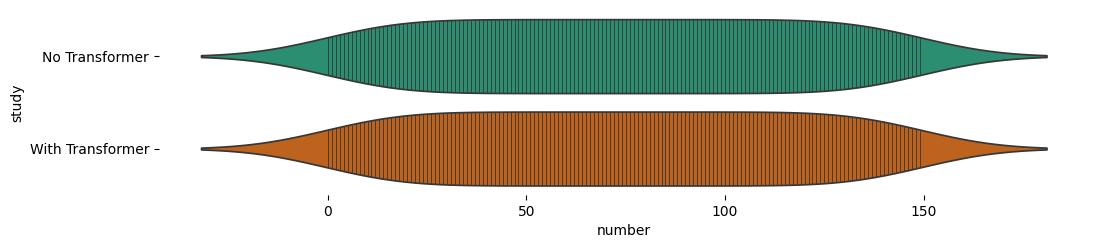

In [ ]:
# @title study vs number

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_combined['study'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_combined, x='number', y='study', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Filter trials based on study
df_no_tr = df_combined[df_combined['study'] == 'No Transformer']
df_w_tr = df_combined[df_combined['study'] == 'With Transformer']

# Summary statistics
summary = pd.DataFrame({
    'Configuration': ['No Transformer', 'With Transformer'],
    'Mean Steps': [df_no_tr['value'].mean(), df_w_tr['value'].mean()],
    'Median Steps': [df_no_tr['value'].median(), df_w_tr['value'].median()],
    'Min Steps': [df_no_tr['value'].min(), df_w_tr['value'].min()],
    'Max Steps': [df_no_tr['value'].max(), df_w_tr['value'].max()]
})

print(summary)


      Configuration  Mean Steps  Median Steps  Min Steps  Max Steps
0    No Transformer   66.253333          32.0       10.0     1826.0
1  With Transformer   48.066667          28.0       10.0      368.0


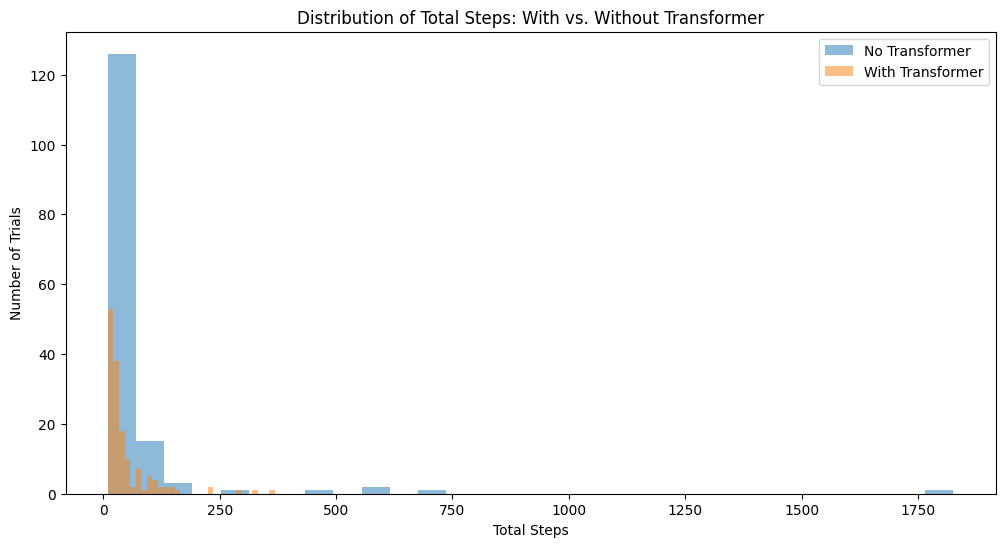

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram for No Transformer
plt.hist(df_no_tr['value'], bins=30, alpha=0.5, label='No Transformer')

# Histogram for With Transformer
plt.hist(df_w_tr['value'], bins=30, alpha=0.5, label='With Transformer')

plt.xlabel('Total Steps')
plt.ylabel('Number of Trials')
plt.title('Distribution of Total Steps: With vs. Without Transformer')
plt.legend()
plt.show()


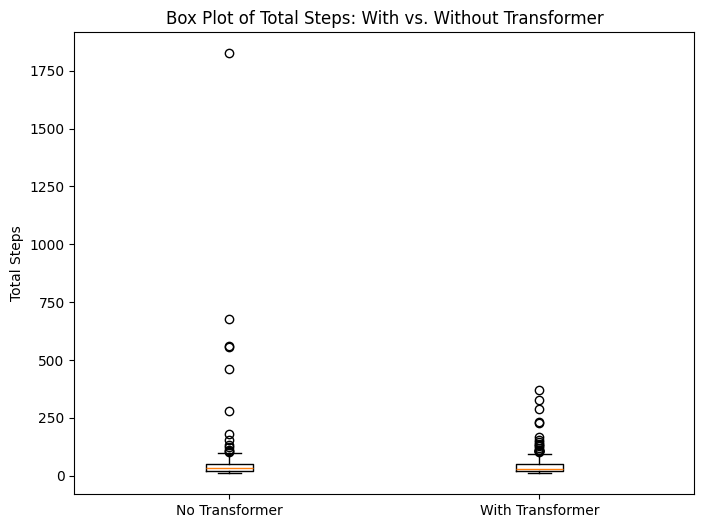

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([df_no_tr['value'], df_w_tr['value']], labels=['No Transformer', 'With Transformer'])
plt.ylabel('Total Steps')
plt.title('Box Plot of Total Steps: With vs. Without Transformer')
plt.show()


<ipython-input-20-8b47adb472b1>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_no_transformer)


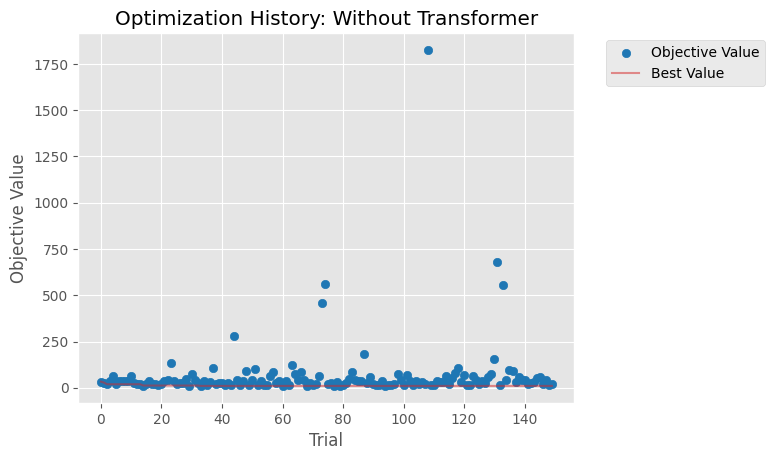

In [ ]:
# Plot optimization history for both studies
optuna.visualization.matplotlib.plot_optimization_history(study_no_transformer)
plt.title('Optimization History: Without Transformer')
plt.show()


<ipython-input-21-32d62acd6e5f>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_with_transformer)


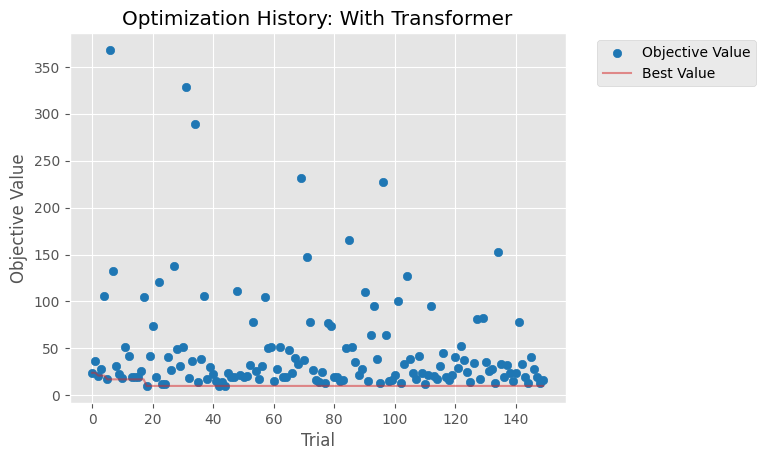

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_with_transformer)
plt.title('Optimization History: With Transformer')
plt.show()

[I 2024-12-04 17:10:20,130] A new study created in memory with name: no-name-aa745dbe-57dd-4600-a6ba-43bff4fbecde
<ipython-input-22-5984797f9794>:8: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_no_transformer)


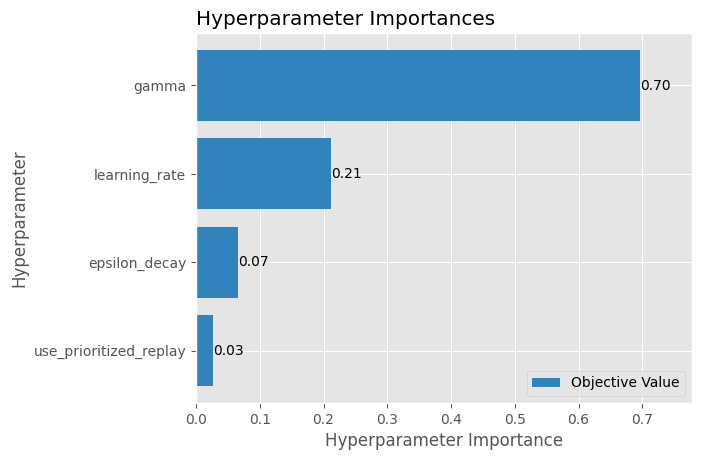

<ipython-input-22-5984797f9794>:12: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_with_transformer)


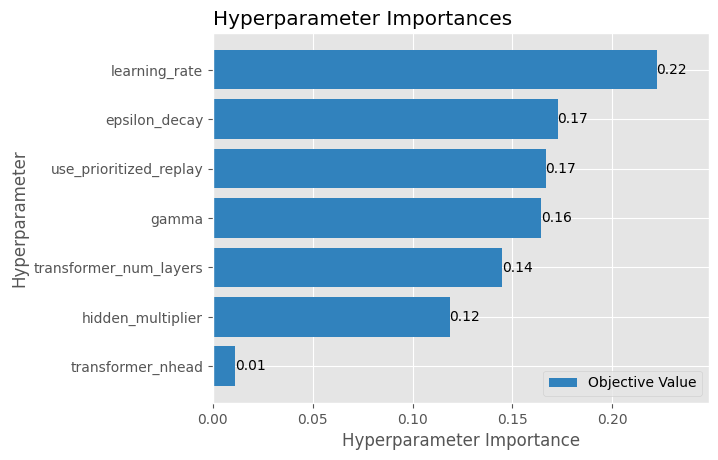

In [ ]:
# Combine both studies for parameter importance
study_combined = optuna.create_study(direction='minimize')
study_combined._storage = study_no_transformer._storage
for trial in study_with_transformer.trials:
    study_combined.add_trial(trial)

# Plot parameter importances for both studies
optuna.visualization.matplotlib.plot_param_importances(study_no_transformer)
plt.title('')
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study_with_transformer)
plt.title('')
plt.show()


[I 2024-12-06 05:18:58,089] A new study created in memory with name: DQN_No_Transformer
[I 2024-12-06 05:18:58,251] Trial 0 finished with value: 23.0 and parameters: {'hidden_size': 196, 'learning_rate': 0.00019433968235201798, 'gamma': 0.9984376857117793, 'epsilon_decay': 0.9582918571853369, 'use_prioritized_replay': True, 'alpha': 0.7663116143709648, 'beta_start': 0.40084782836479005, 'beta_frames': 181803}. Best is trial 0 with value: 23.0.


Trial Parameters (No Transformer): {'hidden_size': 196, 'learning_rate': 0.00019433968235201798, 'gamma': 0.9984376857117793, 'epsilon_decay': 0.9582918571853369, 'use_prioritized_replay': True, 'alpha': 0.7663116143709648, 'beta_start': 0.40084782836479005, 'beta_frames': 181803}
Trial Parameters (No Transformer): {'hidden_size': 116, 'learning_rate': 0.0027381274101882414, 'gamma': 0.9878845482168188, 'epsilon_decay': 0.9323927375179845, 'use_prioritized_replay': False}


[I 2024-12-06 05:18:58,403] Trial 1 finished with value: 20.0 and parameters: {'hidden_size': 116, 'learning_rate': 0.0027381274101882414, 'gamma': 0.9878845482168188, 'epsilon_decay': 0.9323927375179845, 'use_prioritized_replay': False}. Best is trial 1 with value: 20.0.
[I 2024-12-06 05:18:58,538] Trial 2 finished with value: 30.0 and parameters: {'hidden_size': 137, 'learning_rate': 0.007605129231472907, 'gamma': 0.9294075005109225, 'epsilon_decay': 0.9171831477626339, 'use_prioritized_replay': True, 'alpha': 0.4650268471183505, 'beta_start': 0.4317559582857541, 'beta_frames': 101016}. Best is trial 1 with value: 20.0.


Trial Parameters (No Transformer): {'hidden_size': 137, 'learning_rate': 0.007605129231472907, 'gamma': 0.9294075005109225, 'epsilon_decay': 0.9171831477626339, 'use_prioritized_replay': True, 'alpha': 0.4650268471183505, 'beta_start': 0.4317559582857541, 'beta_frames': 101016}
Trial Parameters (No Transformer): {'hidden_size': 165, 'learning_rate': 0.005183585515996668, 'gamma': 0.9948954309560772, 'epsilon_decay': 0.925664266665537, 'use_prioritized_replay': True, 'alpha': 0.45968756509564956, 'beta_start': 0.5138073201158434, 'beta_frames': 161875}


[I 2024-12-06 05:18:58,679] Trial 3 finished with value: 20.0 and parameters: {'hidden_size': 165, 'learning_rate': 0.005183585515996668, 'gamma': 0.9948954309560772, 'epsilon_decay': 0.925664266665537, 'use_prioritized_replay': True, 'alpha': 0.45968756509564956, 'beta_start': 0.5138073201158434, 'beta_frames': 161875}. Best is trial 1 with value: 20.0.
[I 2024-12-06 05:18:58,829] Trial 4 finished with value: 31.0 and parameters: {'hidden_size': 205, 'learning_rate': 0.0005574925227531543, 'gamma': 0.9939355640867732, 'epsilon_decay': 0.9011125953390011, 'use_prioritized_replay': True, 'alpha': 0.4304361395304556, 'beta_start': 0.480635063945775, 'beta_frames': 78534}. Best is trial 1 with value: 20.0.
[I 2024-12-06 05:18:58,839] A new study created in memory with name: DQN_With_Transformer


Trial Parameters (No Transformer): {'hidden_size': 205, 'learning_rate': 0.0005574925227531543, 'gamma': 0.9939355640867732, 'epsilon_decay': 0.9011125953390011, 'use_prioritized_replay': True, 'alpha': 0.4304361395304556, 'beta_start': 0.480635063945775, 'beta_frames': 78534}
Best Hyperparameters (No Transformer):
{'hidden_size': 116, 'learning_rate': 0.0027381274101882414, 'gamma': 0.9878845482168188, 'epsilon_decay': 0.9323927375179845, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 58, 'transformer_num_layers': 1, 'learning_rate': 0.0014272941687183468, 'gamma': 0.9277822092589825, 'epsilon_decay': 0.9161263243779547, 'use_prioritized_replay': True, 'alpha': 0.5100577867723185, 'beta_start': 0.5380914409407214, 'beta_frames': 146504}


[I 2024-12-06 05:18:59,123] Trial 0 finished with value: 29.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 58, 'transformer_num_layers': 1, 'learning_rate': 0.0014272941687183468, 'gamma': 0.9277822092589825, 'epsilon_decay': 0.9161263243779547, 'use_prioritized_replay': True, 'alpha': 0.5100577867723185, 'beta_start': 0.5380914409407214, 'beta_frames': 146504}. Best is trial 0 with value: 29.0.


Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 61, 'transformer_num_layers': 2, 'learning_rate': 0.00041449358500268897, 'gamma': 0.9113929091046052, 'epsilon_decay': 0.946041307548152, 'use_prioritized_replay': False}


[I 2024-12-06 05:18:59,366] Trial 1 finished with value: 60.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 61, 'transformer_num_layers': 2, 'learning_rate': 0.00041449358500268897, 'gamma': 0.9113929091046052, 'epsilon_decay': 0.946041307548152, 'use_prioritized_replay': False}. Best is trial 0 with value: 29.0.


Trial Parameters (With Transformer): {'transformer_nhead': 8, 'hidden_multiplier': 47, 'transformer_num_layers': 4, 'learning_rate': 0.0003392790748887581, 'gamma': 0.906111695846728, 'epsilon_decay': 0.980834054903967, 'use_prioritized_replay': True, 'alpha': 0.5034092099027926, 'beta_start': 0.5713464679502164, 'beta_frames': 62902}


[I 2024-12-06 05:18:59,714] Trial 2 finished with value: 16.0 and parameters: {'transformer_nhead': 8, 'hidden_multiplier': 47, 'transformer_num_layers': 4, 'learning_rate': 0.0003392790748887581, 'gamma': 0.906111695846728, 'epsilon_decay': 0.980834054903967, 'use_prioritized_replay': True, 'alpha': 0.5034092099027926, 'beta_start': 0.5713464679502164, 'beta_frames': 62902}. Best is trial 2 with value: 16.0.
[I 2024-12-06 05:18:59,869] Trial 3 finished with value: 19.0 and parameters: {'transformer_nhead': 2, 'hidden_multiplier': 44, 'transformer_num_layers': 4, 'learning_rate': 0.0001345171698508566, 'gamma': 0.9971919119369962, 'epsilon_decay': 0.9087227984141983, 'use_prioritized_replay': False}. Best is trial 2 with value: 16.0.


Trial Parameters (With Transformer): {'transformer_nhead': 2, 'hidden_multiplier': 44, 'transformer_num_layers': 4, 'learning_rate': 0.0001345171698508566, 'gamma': 0.9971919119369962, 'epsilon_decay': 0.9087227984141983, 'use_prioritized_replay': False}
Trial Parameters (With Transformer): {'transformer_nhead': 4, 'hidden_multiplier': 32, 'transformer_num_layers': 1, 'learning_rate': 0.0032148296648609187, 'gamma': 0.9291464695523299, 'epsilon_decay': 0.9774845737273129, 'use_prioritized_replay': True, 'alpha': 0.41842958555305065, 'beta_start': 0.4063747018781427, 'beta_frames': 134229}


[I 2024-12-06 05:19:00,004] Trial 4 finished with value: 14.0 and parameters: {'transformer_nhead': 4, 'hidden_multiplier': 32, 'transformer_num_layers': 1, 'learning_rate': 0.0032148296648609187, 'gamma': 0.9291464695523299, 'epsilon_decay': 0.9774845737273129, 'use_prioritized_replay': True, 'alpha': 0.41842958555305065, 'beta_start': 0.4063747018781427, 'beta_frames': 134229}. Best is trial 4 with value: 14.0.


Best Hyperparameters (With Transformer):
{'transformer_nhead': 4, 'hidden_multiplier': 32, 'transformer_num_layers': 1, 'learning_rate': 0.0032148296648609187, 'gamma': 0.9291464695523299, 'epsilon_decay': 0.9774845737273129, 'use_prioritized_replay': True, 'alpha': 0.41842958555305065, 'beta_start': 0.4063747018781427, 'beta_frames': 134229}


<ipython-input-5-1c1dbb1ad993>:543: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_agent_no_transformer.eval_net.load_state_dict(torch.load('plain_dqn_best.pth', map_loc

Accuracy (No Transformer): 0.00%


<ipython-input-5-1c1dbb1ad993>:552: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_agent_with_transformer.eval_net.load_state_dict(torch.load('transformer_dqn_best.pth',

Accuracy (With Transformer): 0.00%


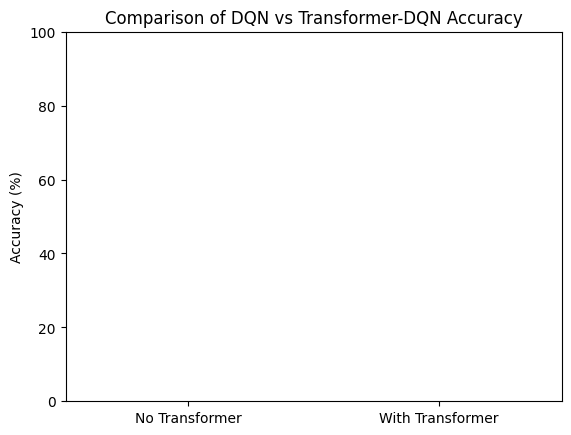

In [ ]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import optuna
import json
import gc
import math
import numpy as np
import logging
import matplotlib.pyplot as plt

# Initialize logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

@dataclass
class Config:
    # Environment Settings
    grid_size: int = 20
    start: tuple = (0, 0)
    destination: tuple = (19, 19)

    # DQN Hyperparameters
    actions: list = ((0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (1, 1), (1, -1), (-1, 1))
    gamma: float = 0.99
    learning_rate: float = 0.001
    batch_size: int = 64
    memory_capacity: int = 10000
    epsilon: float = 1.0
    epsilon_decay: float = 0.995
    epsilon_min: float = 0.1
    target_update: int = 5
    hidden_size: int = 128

    # Transformer-specific hyperparameters
    use_transformer: bool = False
    transformer_nhead: int = 4
    transformer_num_layers: int = 2
    positional_encoding_dim: int = 128

    # Prioritized Replay Buffer hyperparameters
    use_prioritized_replay: bool = False
    alpha: float = 0.6
    beta_start: float = 0.4
    beta_frames: int = 100000

    # Device configuration
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return x

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[data_idx])

    @property
    def total_priority(self):
        return self.tree[0]

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.tree = SumTree(capacity)
        self.alpha = alpha
        self.capacity = capacity
        self.max_priority = 1.0

    def add(self, experience):
        priority = self.max_priority
        self.tree.add(priority ** self.alpha, experience)

    def sample(self, batch_size, beta=0.4):
        batch = []
        idxs = []
        segment = self.tree.total_priority / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, priority, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(priority)

        sampling_probabilities = priorities / self.tree.total_priority
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -beta)
        is_weight /= is_weight.max()
        is_weight = torch.tensor(is_weight, dtype=torch.float)
        return batch, idxs, is_weight

    def update_priorities(self, idxs, priorities):
        for idx, priority in zip(idxs, priorities):
            priority = max(priority, 1e-6)
            self.tree.update(idx, priority ** self.alpha)
            self.max_priority = max(self.max_priority, priority)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, config: Config):
        super(DQN, self).__init__()
        self.use_transformer = config.use_transformer
        self.device = config.device
        self.hidden_size = config.hidden_size

        if self.use_transformer:
            logger.info("Initializing Transformer layers with batch_first=True.")
            self.input_proj = nn.Linear(input_dim, self.hidden_size)
            self.pos_encoder = PositionalEncoding(self.hidden_size)
            assert self.hidden_size % config.transformer_nhead == 0, "hidden_size must be divisible by transformer_nhead"
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.hidden_size,
                    nhead=config.transformer_nhead,
                    batch_first=True
                ),
                num_layers=config.transformer_num_layers
            )
            self.fc = nn.Sequential(
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, output_dim)
            )
        else:
            logger.info("Initializing fully connected layers without Transformer.")
            self.fc = nn.Sequential(
                nn.Linear(input_dim, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, output_dim)
            )

        self.to(self.device)

    def forward(self, x):
        if self.use_transformer:
            x = self.input_proj(x)
            x = x.unsqueeze(1)
            x = self.pos_encoder(x)
            x = self.transformer(x)
            x = x.squeeze(1)
        return self.fc(x)

class Agent:
    def __init__(self, config: Config):
        self.config = config
        self.device = config.device
        self.eval_net = DQN(input_dim=2, output_dim=len(config.actions), config=config)
        self.target_net = DQN(input_dim=2, output_dim=len(config.actions), config=config)
        self.target_net.load_state_dict(self.eval_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=config.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.epsilon = config.epsilon

        if config.use_prioritized_replay:
            self.memory = PrioritizedReplayBuffer(config.memory_capacity, alpha=config.alpha)
            self.beta = config.beta_start
            self.beta_increment = (1.0 - config.beta_start) / config.beta_frames
        else:
            self.memory = deque(maxlen=config.memory_capacity)

        logger.info(f"Eval Net is on device: {next(self.eval_net.parameters()).device}")
        logger.info(f"Target Net is on device: {next(self.target_net.parameters()).device}")

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, len(self.config.actions) - 1)
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.eval_net(state)
        return torch.argmax(q_values).item()

    def store_transition(self, transition):
        if self.config.use_prioritized_replay:
            self.memory.add(transition)
        else:
            self.memory.append(transition)

    def train_step(self):
        if self.config.use_prioritized_replay:
            if self.memory.tree.n_entries < self.config.batch_size:
                return
            batch, idxs, is_weights = self.memory.sample(self.config.batch_size, self.beta)
            is_weights = is_weights.to(self.device).unsqueeze(1)
            self.beta = min(1.0, self.beta + self.beta_increment)
        else:
            if len(self.memory) < self.config.batch_size:
                return
            batch = random.sample(self.memory, self.config.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float).unsqueeze(1).to(self.device)

        q_eval = self.eval_net(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            q_next = self.target_net(next_states).max(1)[0].unsqueeze(1)

        q_target = rewards + self.config.gamma * q_next * (1 - dones)

        if self.config.use_prioritized_replay:
            td_errors = q_target.squeeze(1) - q_eval
            loss = (torch.pow(td_errors, 2) * is_weights.squeeze(1)).mean()
        else:
            loss = self.loss_fn(q_eval, q_target.squeeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.config.use_prioritized_replay:
            new_priorities = torch.abs(td_errors.detach()).cpu().numpy() + 1e-6
            self.memory.update_priorities(idxs, new_priorities)

        if self.epsilon > self.config.epsilon_min:
            self.epsilon *= self.config.epsilon_decay

    def update_target_network(self):
        self.target_net.load_state_dict(self.eval_net.state_dict())

class GridEnvironment:
    def __init__(self, config: Config):
        self.config = config
        self.grid_size = config.grid_size
        self.start = config.start
        self.destination = config.destination
        self.reset()

    def reset(self):
        self.robot_pos = self.start
        self.steps = 0
        self.done = False
        return self.robot_pos

    def step(self, action):
        if not isinstance(action, int):
            raise ValueError("Action must be an integer representing the action index.")
        dx, dy = self.config.actions[action]
        new_x = self.robot_pos[0] + dx
        new_y = self.robot_pos[1] + dy

        if not (0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size):
            reward = -100
            done = True
            next_state = self.robot_pos
        else:
            next_state = (new_x, new_y)
            reward = -1
            done = next_state == self.destination

        self.robot_pos = next_state
        self.steps += 1
        return next_state, reward, done

def objective_no_transformer(trial):
    use_transformer = False
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.90, 0.999)
    use_prioritized_replay = trial.suggest_categorical('use_prioritized_replay', [True, False])
    if use_prioritized_replay:
        alpha = trial.suggest_float('alpha', 0.4, 0.8)
        beta_start = trial.suggest_float('beta_start', 0.4, 0.6)
        beta_frames = trial.suggest_int('beta_frames', 50000, 200000)
    else:
        alpha = 0.6
        beta_start = 0.4
        beta_frames = 100000

    config = Config(
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        gamma=gamma,
        epsilon_decay=epsilon_decay,
        use_transformer=use_transformer,
        use_prioritized_replay=use_prioritized_replay,
        alpha=alpha,
        beta_start=beta_start,
        beta_frames=beta_frames
    )

    print(f"Trial Parameters (No Transformer): {trial.params}")

    try:
        agent = Agent(config)
    except AssertionError as e:
        raise optuna.exceptions.TrialPruned(f"AssertionError: {e}")

    env = GridEnvironment(config)
    episode = 0
    num_episodes = 10
    max_steps_per_episode = 100
    total_steps = 0

    while episode < num_episodes:
        robot_pos = env.reset()
        done = False
        while not done and env.steps < max_steps_per_episode:
            action = agent.choose_action(robot_pos)
            next_state, reward, done = env.step(action)
            agent.store_transition((list(robot_pos), action, reward, list(next_state), done))
            agent.train_step()
            robot_pos = next_state
            total_steps += 1
        episode += 1
        if episode % config.target_update == 0:
            agent.update_target_network()

    del agent
    del config
    del env
    torch.cuda.empty_cache()
    gc.collect()

    return total_steps

def objective_with_transformer(trial):
    use_transformer = True
    transformer_nhead = trial.suggest_categorical('transformer_nhead', [2, 4, 8])
    hidden_multiplier = trial.suggest_int('hidden_multiplier', 16, 64)
    hidden_size = transformer_nhead * hidden_multiplier
    transformer_num_layers = trial.suggest_int('transformer_num_layers', 1, 4)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.90, 0.999)
    use_prioritized_replay = trial.suggest_categorical('use_prioritized_replay', [True, False])
    if use_prioritized_replay:
        alpha = trial.suggest_float('alpha', 0.4, 0.8)
        beta_start = trial.suggest_float('beta_start', 0.4, 0.6)
        beta_frames = trial.suggest_int('beta_frames', 50000, 200000)
    else:
        alpha = 0.6
        beta_start = 0.4
        beta_frames = 100000

    config = Config(
        hidden_size=hidden_size,
        learning_rate=learning_rate,
        gamma=gamma,
        epsilon_decay=epsilon_decay,
        use_transformer=use_transformer,
        transformer_nhead=transformer_nhead,
        transformer_num_layers=transformer_num_layers,
        use_prioritized_replay=use_prioritized_replay,
        alpha=alpha,
        beta_start=beta_start,
        beta_frames=beta_frames
    )

    print(f"Trial Parameters (With Transformer): {trial.params}")

    try:
        agent = Agent(config)
    except AssertionError as e:
        raise optuna.exceptions.TrialPruned(f"AssertionError: {e}")

    env = GridEnvironment(config)
    episode = 0
    num_episodes = 10
    max_steps_per_episode = 100
    total_steps = 0

    while episode < num_episodes:
        robot_pos = env.reset()
        done = False
        while not done and env.steps < max_steps_per_episode:
            action = agent.choose_action(robot_pos)
            next_state, reward, done = env.step(action)
            agent.store_transition((list(robot_pos), action, reward, list(next_state), done))
            agent.train_step()
            robot_pos = next_state
            total_steps += 1
        episode += 1
        if episode % config.target_update == 0:
            agent.update_target_network()

    del agent
    del config
    del env
    torch.cuda.empty_cache()
    gc.collect()

    return total_steps

# Optimize hyperparameters
n_trials = 15  # For demonstration, use fewer trials. Increase as needed.
timeout_seconds = 600  # For demonstration, shorter timeout. Adjust as needed.

study_no_transformer = optuna.create_study(direction='minimize', study_name='DQN_No_Transformer')
study_no_transformer.optimize(objective_no_transformer, n_trials=n_trials, timeout=timeout_seconds)

print("Best Hyperparameters (No Transformer):")
print(study_no_transformer.best_params)

with open('best_hyperparameters_no_transformer.json', 'w') as f:
    json.dump(study_no_transformer.best_params, f, indent=4)

study_with_transformer = optuna.create_study(direction='minimize', study_name='DQN_With_Transformer')
study_with_transformer.optimize(objective_with_transformer, n_trials=n_trials, timeout=timeout_seconds)

print("Best Hyperparameters (With Transformer):")
print(study_with_transformer.best_params)

with open('best_hyperparameters_with_transformer.json', 'w') as f:
    json.dump(study_with_transformer.best_params, f, indent=4)

# Train final agents with best hyperparameters from both studies
def train_final_agent(params, use_transformer, num_episodes=500):
    # Rebuild config from best params
    config = Config(
        hidden_size=params.get('hidden_size', 128),
        learning_rate=params.get('learning_rate', 0.001),
        gamma=params.get('gamma', 0.99),
        epsilon_decay=params.get('epsilon_decay', 0.995),
        use_transformer=use_transformer,
        use_prioritized_replay=params.get('use_prioritized_replay', False),
        alpha=params.get('alpha', 0.6),
        beta_start=params.get('beta_start', 0.4),
        beta_frames=params.get('beta_frames', 100000),
        transformer_nhead=params.get('transformer_nhead', 4),
        transformer_num_layers=params.get('transformer_num_layers', 2)
    )

    env = GridEnvironment(config)
    agent = Agent(config)

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        max_steps_per_episode = 100
        while not done and steps < max_steps_per_episode:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.store_transition((list(state), action, reward, list(next_state), done))
            agent.train_step()
            state = next_state
            steps += 1
        if (ep + 1) % config.target_update == 0:
            agent.update_target_network()
    return agent, config

# Train final model (No Transformer)
final_agent_no_transformer, config_no_transformer = train_final_agent(study_no_transformer.best_params, use_transformer=False)
torch.save(final_agent_no_transformer.eval_net.state_dict(), 'plain_dqn_best.pth')

# Train final model (With Transformer)
final_agent_with_transformer, config_with_transformer = train_final_agent(study_with_transformer.best_params, use_transformer=True)
torch.save(final_agent_with_transformer.eval_net.state_dict(), 'transformer_dqn_best.pth')

def test_agent(agent, env, num_test_episodes=50, max_steps=100):
    success_count = 0
    for episode in range(num_test_episodes):
        state = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            # Greedy action selection
            state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                q_values = agent.eval_net(state_tensor)
            action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            state = next_state
            steps += 1

        if state == env.config.destination:
            success_count += 1
    accuracy = (success_count / num_test_episodes) * 100.0
    return accuracy

# Load and test accuracy for No Transformer agent
test_agent_no_transformer = Agent(config_no_transformer)
test_agent_no_transformer.eval_net.load_state_dict(torch.load('plain_dqn_best.pth', map_location=test_agent_no_transformer.device))
test_agent_no_transformer.eval_net.eval()

env_no_transformer = GridEnvironment(config_no_transformer)
accuracy_no_transformer = test_agent(test_agent_no_transformer, env_no_transformer)
print(f"Accuracy (No Transformer): {accuracy_no_transformer:.2f}%")

# Load and test accuracy for Transformer agent
test_agent_with_transformer = Agent(config_with_transformer)
test_agent_with_transformer.eval_net.load_state_dict(torch.load('transformer_dqn_best.pth', map_location=test_agent_with_transformer.device))
test_agent_with_transformer.eval_net.eval()

env_with_transformer = GridEnvironment(config_with_transformer)
accuracy_with_transformer = test_agent(test_agent_with_transformer, env_with_transformer)
print(f"Accuracy (With Transformer): {accuracy_with_transformer:.2f}%")

# Plot comparison
labels = ['No Transformer', 'With Transformer']
accuracies = [accuracy_no_transformer, accuracy_with_transformer]

plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Comparison of DQN vs Transformer-DQN Accuracy')
plt.ylim([0, 100])
plt.show()
